# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [1]:
import time
import datetime
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from LANAM.models import LaNAM, BayesianLinearRegression

from LANAM.trainer.training import *
from LANAM.trainer.nam_training import *
from LANAM.trainer.marglik_training import *
from LANAM.trainer.wandb_train import wandb_training

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset

from LANAM.config.default import defaults
from LANAM.utils.plotting import * 

import matplotlib.pyplot as plt 
import numpy as np


from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

from nam.config import defaults as namDefaults
from nam.models import NAM
from nam.utils import *
from nam.data import NAMDataset

import wandb

In [2]:
%reload_ext autoreload 
%autoreload 2

In [3]:
wandb.login()
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xinyu-zhang. Use `wandb login --relogin` to force relogin


0.7


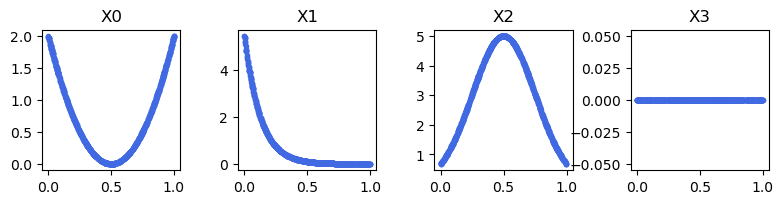

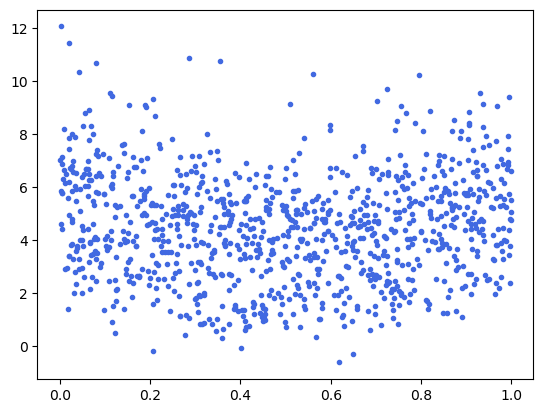

In [4]:
cfg = defaults()

gen_funcs, gen_func_names = task()
in_features = len(gen_funcs)
sigma = cfg.prior_sigma_noise
print(sigma)
trainset = ToyDataset(gen_funcs, gen_func_names, num_samples=1000, sigma=sigma)
valset = ToyDataset(gen_funcs, gen_func_names, num_samples=200, sigma=sigma)
testset = ToyDataset(gen_funcs, gen_func_names, num_samples=50, use_test=True)
datasets= [trainset, valset, testset]
trainset.plot()

train_loader, train_loader_fnn = trainset.loader, trainset.loader_fnn
val_loader, val_loader_fnn = valset.loader, valset.loader_fnn
X_test, y_test = testset.X, testset.y

In [8]:
def load_and_log(datasets, project, job_type, description):
    # start a run with specified project and a descriptive job tag 
    with wandb.init(project=project, job_type=job_type) as run:
        
        names = ["training", "validation", "test"]

        # create Artifact, with user-defined description and meta-data
        raw_data = wandb.Artifact(
            "synthetic-4", type="dataset",
            description="synthetic samples with 4 input features, split into train/val/test",
            metadata={"sizes": [len(dataset) for dataset in datasets]})

        for name, data in zip(names, datasets):
            # Store a new file in the artifact, and write something into its contents.
            with raw_data.new_file(name + ".pt", mode="wb") as file:
                X, y, fnn = data.X, data.y, data.fnn
                torch.save((X, y, fnn), file)

        # Save the artifact to W&B.
        run.log_artifact(raw_data)

load_data = False
if load_data:
    load_and_log(datasets, project, job_type, description)

In [6]:
# note that non-iterative type is invalid for wandb parameters_list
# note that log_uniform will add base exponents;
# while log_uniform_values expects specified values. 
"""parameters_list = {
    'lr': {
        'values': [0.1, 0.01, 0.001]
    }, 
    'lr_hyp': {
        'values': [0.1, 0.01, 0.001]
    }, 
    'n_epochs_burnin': {
        'values': [1, 20, 50]
    }, 
    'n_hypersteps': {
        'values': [30, 50, 70]
    }, 
    'marglik_frequency': {
        'values': [50, 100, 200]
    },
    'activation_cls': {
        'values': ['gelu', 'relu', 'elu', 'leakyrelu']
    }, 
}"""
parameters_list = {
    'lr': {
        'values': [0.01, 0.001]
    }, 
    'lr_hyp': {
        'values': [0.1, 0.01]
    }, 
    'activation_cls': {
        'values': ['gelu', 'relu', 'leakyrelu', 'elu']
    }, 
    'hidden_sizes': {
        'values':[64, 1024] # single hidden layer
    }
}
sweep_configuration = {
    'method': 'grid', 
    'name': 'sweep',
    'parameters': parameters_list, 
}
# initialize the sweep 
sweep_id = wandb.sweep(
    sweep=sweep_configuration, 
    project='LANAM-grid-basic-synthetic',
)
#sweep_id = 4wdr0f24
#print(f"sweep id: {sweep_id}")

Create sweep with ID: le5quftx
Sweep URL: https://wandb.ai/xinyu-zhang/LANAM-grid-basic-synthetic/sweeps/le5quftx


wandb: Agent Starting Run: dxreujrq with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.729, epoch_perf= 0.539
tensor([0.1349, 0.1273, 0.1223, 0.9339], grad_fn=<ExpBackward0>) tensor([0.4169, 0.4263, 0.4235, 0.4007], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.507, epoch_perf= 0.502
tensor([0.1075, 0.0783, 0.0725, 1.5852], grad_fn=<ExpBackward0>) tensor([0.3691, 0.3934, 0.3869, 0.3359], grad_fn

wandb: Agent Starting Run: 61g1hyr3 with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.738, epoch_perf= 0.551
tensor([0.7543, 0.7541, 0.7539, 0.7592], grad_fn=<ExpBackward0>) tensor([0.7505, 0.7505, 0.7505, 0.7505], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.593, epoch_perf= 0.520
tensor([0.5873, 0.5836, 0.5877, 0.7086], grad_fn=<ExpBackward0>) tensor([0.5682, 0.5684, 0.5685, 0.5680], grad_f

wandb: Agent Starting Run: c8luv1pj with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.097, epoch_perf= 0.858
tensor([0.1331, 0.1224, 0.1174, 0.1260], grad_fn=<ExpBackward0>) tensor([0.5183, 0.5201, 0.5252, 0.5069], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.575, epoch_perf= 0.565
tensor([0.0847, 0.0630, 0.0618, 0.0857], grad_fn=<ExpBackward0>) tensor([0.4004, 0.4061, 0.4063, 0.3777], grad_f

wandb: Agent Starting Run: r4te47h6 with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.333, epoch_perf= 1.097
tensor([0.7542, 0.7541, 0.7538, 0.7542], grad_fn=<ExpBackward0>) tensor([0.7540, 0.7540, 0.7540, 0.7539], grad_fn=<ExpBackward0>)


/scratch/work/zhangx18/Reproduced-LA-NAM/LANAM/utils/plotting.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_indiv, axs = plt.subplots(rows, cols, figsize=figsize)


EPOCH=201: epoch_loss= 0.732, epoch_perf= 0.617
tensor([0.5628, 0.5541, 0.5807, 0.5980], grad_fn=<ExpBackward0>) tensor([0.5630, 0.5631, 0.5628, 0.5626], grad_fn=<ExpBackward0>)
EPOCH=301: epoch_loss= 0.603, epoch_perf= 0.552
tensor([0.4409, 0.4115, 0.4652, 0.5012], grad_fn=<ExpBackward0>) tensor([0.4419, 0.4424, 0.4417, 0.4412], grad_fn=<ExpBackward0>)
MARGLIK: finished training. Recover best model and fit Laplace.


wandb: Agent Starting Run: u9j70989 with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.819, epoch_perf= 0.564
tensor([0.1255, 0.1240, 0.1153, 0.3644], grad_fn=<ExpBackward0>) tensor([0.4279, 0.4394, 0.4300, 0.4120], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.560, epoch_perf= 0.554
tensor([0.0864, 0.0743, 0.0577, 0.9428], grad_fn=<ExpBackward0>) tensor([0.3879, 0.4149, 0.3929, 0.3534], g

wandb: Agent Starting Run: ksc1sfvf with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.839, epoch_perf= 0.585
tensor([0.7540, 0.7540, 0.7537, 0.7583], grad_fn=<ExpBackward0>) tensor([0.7507, 0.7507, 0.7507, 0.7506], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.645, epoch_perf= 0.555
tensor([0.5997, 0.5867, 0.5900, 0.7958], grad_fn=<ExpBackward0>) tensor([0.5695, 0.5698, 0.5696, 0.5692], 

wandb: Agent Starting Run: jlw3f140 with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.655, epoch_perf= 0.699
tensor([0.1114, 0.1113, 0.1105, 0.1127], grad_fn=<ExpBackward0>) tensor([0.4763, 0.4792, 0.4791, 0.4699], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.641, epoch_perf= 0.618
tensor([0.0503, 0.0481, 0.0482, 0.0541], grad_fn=<ExpBackward0>) tensor([0.4081, 0.4229, 0.4123, 0.3946], 

wandb: Agent Starting Run: l57089pu with config:
wandb: 	activation_cls: gelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='gelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.719, epoch_perf= 0.699
tensor([0.7536, 0.7536, 0.7536, 0.7536], grad_fn=<ExpBackward0>) tensor([0.7513, 0.7513, 0.7513, 0.7512], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.936, epoch_perf= 0.620
tensor([0.5999, 0.5933, 0.5946, 0.6203], grad_fn=<ExpBackward0>) tensor([0.5709, 0.5713, 0.5710, 0.5708],

wandb: Agent Starting Run: yn9ssqcr with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.619, epoch_perf= 0.490
tensor([0.8133, 0.3851, 0.4494, 0.8877], grad_fn=<ExpBackward0>) tensor([0.4320, 0.4140, 0.4496, 0.3257], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.496, epoch_perf= 0.483
tensor([0.6941, 0.2779, 0.4334, 0.8051], grad_fn=<ExpBackward0>) tensor([0.4007, 0.3754, 0.4328, 0.2545], grad_fn=<ExpBackward0>)
E

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j7wiwbb5 with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.618, epoch_perf= 0.485
tensor([0.7636, 0.7584, 0.7579, 0.7680], grad_fn=<ExpBackward0>) tensor([0.7504, 0.7504, 0.7505, 0.7502], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.540, epoch_perf= 0.484
tensor([0.6441, 0.5866, 0.6054, 0.8327], grad_fn=<ExpBackward0>) tensor([0.5693, 0.5688, 0.5695, 0.5678], grad_fn=<ExpBackward0>)


wandb: Agent Starting Run: bmt976e8 with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.880, epoch_perf= 0.716
tensor([0.2095, 0.2178, 0.1568, 0.3251], grad_fn=<ExpBackward0>) tensor([0.4698, 0.5174, 0.4863, 0.4770], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.514, epoch_perf= 0.504
tensor([0.2193, 0.2138, 0.2410, 0.4124], grad_fn=<ExpBackward0>) tensor([0.3434, 0.4091, 0.4254, 0.3570], grad_fn=<ExpBackward0>)


wandb: Agent Starting Run: 1y16jzlb with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.835, epoch_perf= 0.658
tensor([0.7577, 0.7564, 0.7557, 0.7562], grad_fn=<ExpBackward0>) tensor([0.7514, 0.7513, 0.7513, 0.7512], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.582, epoch_perf= 0.501
tensor([0.6088, 0.5714, 0.5835, 0.6090], grad_fn=<ExpBackward0>) tensor([0.5670, 0.5665, 0.5664, 0.5658], grad_fn=<ExpBackward0>)

wandb: Agent Starting Run: 00xvc4ex with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.673, epoch_perf= 0.515
tensor([1.0825, 0.9119, 0.8458, 1.0682], grad_fn=<ExpBackward0>) tensor([0.4639, 0.4894, 0.4913, 0.2692], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.564, epoch_perf= 0.531
tensor([0.9290, 0.5857, 0.6680, 0.8955], grad_fn=<ExpBackward0>) tensor([0.4075, 0.4232, 0.4724, 0.2186], grad_fn=<ExpBackwar

wandb: Agent Starting Run: 27bilgu2 with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.703, epoch_perf= 0.547
tensor([0.8817, 0.7729, 0.7679, 0.7595], grad_fn=<ExpBackward0>) tensor([0.7515, 0.7516, 0.7517, 0.7505], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.603, epoch_perf= 0.540
tensor([0.8076, 0.6197, 0.6410, 0.6566], grad_fn=<ExpBackward0>) tensor([0.5700, 0.5712, 0.5723, 0.5690], grad_fn=<ExpBackwa

wandb: Agent Starting Run: l5ilnrjt with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.235, epoch_perf= 0.512
tensor([0.2218, 0.1833, 0.1821, 0.1600], grad_fn=<ExpBackward0>) tensor([0.4746, 0.4656, 0.4862, 0.3418], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.501, epoch_perf= 0.474
tensor([0.2388, 0.1729, 0.1816, 0.2285], grad_fn=<ExpBackward0>) tensor([0.3859, 0.3863, 0.3993, 0.3774], grad_fn=<ExpBackwa

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7nywkl13 with config:
wandb: 	activation_cls: relu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='relu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.126, epoch_perf= 0.486
tensor([0.7553, 0.7550, 0.7549, 0.7544], grad_fn=<ExpBackward0>) tensor([0.7508, 0.7508, 0.7509, 0.7504], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.658, epoch_perf= 0.481
tensor([0.6236, 0.6140, 0.6100, 0.6298], grad_fn=<ExpBackward0>) tensor([0.5706, 0.5704, 0.5696, 0.5688], grad_fn=<ExpBackw

wandb: Agent Starting Run: 0t8f7ugd with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.649, epoch_perf= 0.518
tensor([0.8063, 0.3548, 0.2061, 0.9220], grad_fn=<ExpBackward0>) tensor([0.4476, 0.4426, 0.4151, 0.3585], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.489, epoch_perf= 0.478
tensor([0.6582, 0.2606, 0.3044, 0.9115], grad_fn=<ExpBackward0>) tensor([0.4064, 0.3911, 0.3870, 0.283

wandb: Agent Starting Run: xtbta4d5 with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.616, epoch_perf= 0.487
tensor([0.7624, 0.7577, 0.7554, 0.7961], grad_fn=<ExpBackward0>) tensor([0.7504, 0.7504, 0.7503, 0.7502], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.532, epoch_perf= 0.477
tensor([0.6260, 0.5825, 0.5917, 0.9301], grad_fn=<ExpBackward0>) tensor([0.5682, 0.5675, 0.5678, 0.56

wandb: Agent Starting Run: 5kf4bu0u with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.799, epoch_perf= 0.614
tensor([0.3588, 0.2024, 0.2450, 0.3298], grad_fn=<ExpBackward0>) tensor([0.4559, 0.4560, 0.4970, 0.4220], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.501, epoch_perf= 0.489
tensor([0.3617, 0.1636, 0.2525, 0.4327], grad_fn=<ExpBackward0>) tensor([0.3899, 0.3683, 0.4081, 0.34

wandb: Agent Starting Run: b24yuol7 with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.776, epoch_perf= 0.606
tensor([0.7572, 0.7555, 0.7549, 0.7600], grad_fn=<ExpBackward0>) tensor([0.7510, 0.7510, 0.7509, 0.7510], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.588, epoch_perf= 0.513
tensor([0.6012, 0.5736, 0.5773, 0.6446], grad_fn=<ExpBackward0>) tensor([0.5676, 0.5674, 0.5664, 0.5

wandb: Agent Starting Run: vn4evxsx with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.638, epoch_perf= 0.485
tensor([1.1085, 0.9369, 0.8802, 0.8709], grad_fn=<ExpBackward0>) tensor([0.4323, 0.4458, 0.5178, 0.2553], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.508, epoch_perf= 0.477
tensor([0.8657, 0.4934, 0.6817, 0.8264], grad_fn=<ExpBackward0>) tensor([0.3944, 0.3990, 0.4514,

wandb: Agent Starting Run: 24ypvprx with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.657, epoch_perf= 0.504
tensor([0.8622, 0.7654, 0.7659, 0.7642], grad_fn=<ExpBackward0>) tensor([0.7512, 0.7510, 0.7514, 0.7503], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.556, epoch_perf= 0.492
tensor([0.8712, 0.6401, 0.6353, 0.6526], grad_fn=<ExpBackward0>) tensor([0.5694, 0.5719, 0.5706

wandb: Agent Starting Run: w8umxf9f with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.161, epoch_perf= 0.522
tensor([0.2199, 0.2040, 0.1995, 0.1890], grad_fn=<ExpBackward0>) tensor([0.4639, 0.4797, 0.4950, 0.3471], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.500, epoch_perf= 0.473
tensor([0.2091, 0.2264, 0.1863, 0.3075], grad_fn=<ExpBackward0>) tensor([0.3616, 0.4283, 0.3810

wandb: Agent Starting Run: brdkbdvu with config:
wandb: 	activation_cls: leakyrelu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='leakyrelu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.192, epoch_perf= 0.485
tensor([0.7548, 0.7551, 0.7549, 0.7544], grad_fn=<ExpBackward0>) tensor([0.7508, 0.7509, 0.7509, 0.7504], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.682, epoch_perf= 0.485
tensor([0.6158, 0.6156, 0.6123, 0.6269], grad_fn=<ExpBackward0>) tensor([0.5698, 0.5714, 0.571

wandb: Agent Starting Run: kbe5gqux with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.817, epoch_perf= 0.600
tensor([0.1481, 0.1264, 0.1292, 0.3448], grad_fn=<ExpBackward0>) tensor([0.4497, 0.4417, 0.4659, 0.4163], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.534, epoch_perf= 0.527
tensor([0.1481, 0.0641, 0.0899, 0.4568], grad_fn=<ExpBackward0>) tensor([0.3974, 0.3815, 0.4213, 0.3301], grad_fn=<ExpBackwa

wandb: Agent Starting Run: ceuhsp28 with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 0.818, epoch_perf= 0.601
tensor([0.7545, 0.7541, 0.7540, 0.7579], grad_fn=<ExpBackward0>) tensor([0.7508, 0.7508, 0.7508, 0.7507], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.639, epoch_perf= 0.546
tensor([0.5887, 0.5706, 0.5839, 0.6760], grad_fn=<ExpBackward0>) tensor([0.5689, 0.5690, 0.5690, 0.5685], grad_fn=<ExpBackw

wandb: Agent Starting Run: pts130e9 with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 2.845, epoch_perf= 2.679
tensor([0.1318, 0.1292, 0.1244, 0.1327], grad_fn=<ExpBackward0>) tensor([0.8318, 0.8542, 0.8712, 0.7993], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.928, epoch_perf= 0.904
tensor([0.1087, 0.0939, 0.0638, 0.1222], grad_fn=<ExpBackward0>) tensor([0.4723, 0.4842, 0.5129, 0.4382], grad_fn=<ExpBackw

wandb: Agent Starting Run: 8i4ohwuc with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [64]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[64], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 2.906, epoch_perf= 2.738
tensor([0.7542, 0.7541, 0.7542, 0.7542], grad_fn=<ExpBackward0>) tensor([0.8110, 0.8116, 0.8132, 0.8107], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 1.189, epoch_perf= 1.072
tensor([0.5692, 0.5709, 0.5394, 0.5968], grad_fn=<ExpBackward0>) tensor([0.5926, 0.5932, 0.5950, 0.5919], grad_fn=<ExpBack

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i4amen5c with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.122, epoch_perf= 0.671
tensor([0.1201, 0.1180, 0.1154, 0.1290], grad_fn=<ExpBackward0>) tensor([0.4729, 0.4718, 0.4839, 0.4457], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.606, epoch_perf= 0.594
tensor([0.0733, 0.0606, 0.0590, 0.1173], grad_fn=<ExpBackward0>) tensor([0.4147, 0.4091, 0.4323, 0.3583], grad_fn=<Exp

wandb: Agent Starting Run: p0khqwls with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.01
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.01, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 1.218, epoch_perf= 0.775
tensor([0.7539, 0.7538, 0.7537, 0.7541], grad_fn=<ExpBackward0>) tensor([0.7517, 0.7517, 0.7518, 0.7517], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 0.773, epoch_perf= 0.632
tensor([0.6010, 0.5944, 0.5940, 0.6775], grad_fn=<ExpBackward0>) tensor([0.5703, 0.5703, 0.5706, 0.5699], grad_fn=<Ex

wandb: Agent Starting Run: c4aj993f with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.1, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 2.294, epoch_perf= 0.984
tensor([0.1120, 0.1119, 0.1111, 0.1114], grad_fn=<ExpBackward0>) tensor([0.5451, 0.5439, 0.5530, 0.5273], grad_fn=<ExpBackward0>)


Run c4aj993f errored: _LinAlgError('linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 716 is not positive-definite).')
wandb: ERROR Run c4aj993f errored: _LinAlgError('linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 716 is not positive-definite).')
wandb: Agent Starting Run: thpkhbyo with config:
wandb: 	activation_cls: elu
wandb: 	hidden_sizes: [1024]
wandb: 	lr: 0.001
wandb: 	lr_hyp: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: 
 Config(experiment_name='LANAM-Grid-1', data_path='LANAM/data/datasets', likelihood='regression', prior_sigma_noise=0.7, num_epochs=400, batch_size=128, wandb=False, log_loss_frequency=100, lr=0.001, lr_hyp=0.01, n_epochs_burnin=50, n_hypersteps=30, marglik_frequency=100, hidden_sizes=[1024], activation=True, activation_cls='elu')
Model summary: 
 LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1024, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=1024, out_features=1, bias=True)
      )
    )
  )
)
EPOCH=101: epoch_loss= 2.219, epoch_perf= 0.906
tensor([0.7536, 0.7536, 0.7536, 0.7536], grad_fn=<ExpBackward0>) tensor([0.7526, 0.7526, 0.7526, 0.7525], grad_fn=<ExpBackward0>)
EPOCH=201: epoch_loss= 1.082, epoch_perf= 0.652
tensor([0.5951, 0.5913, 0.5910, 0.6122], grad_fn=<ExpBackward0>) tensor([0.5690, 0.5690, 0.5690, 0.5686], grad_fn=<E

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


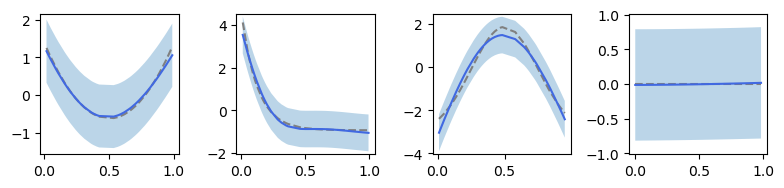

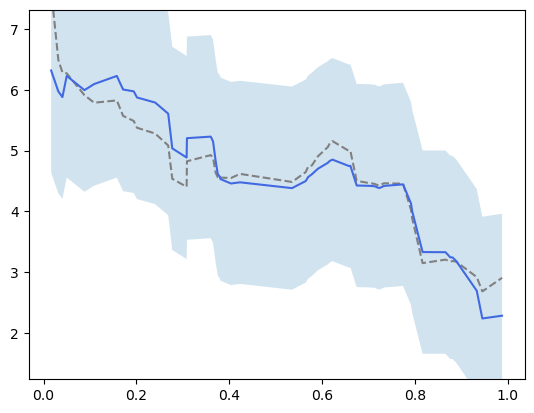

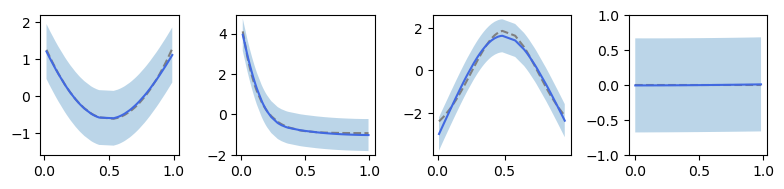

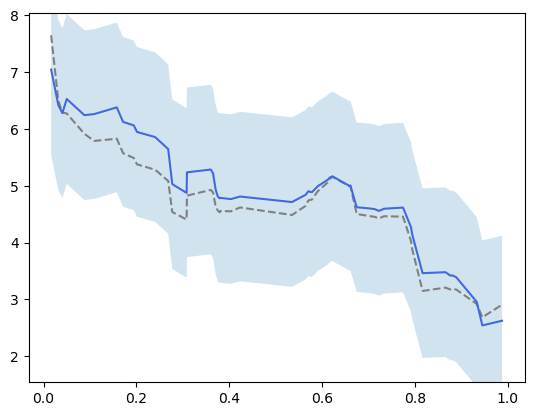

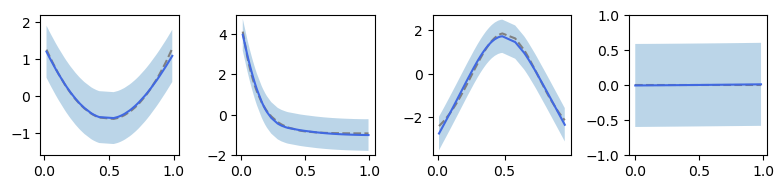

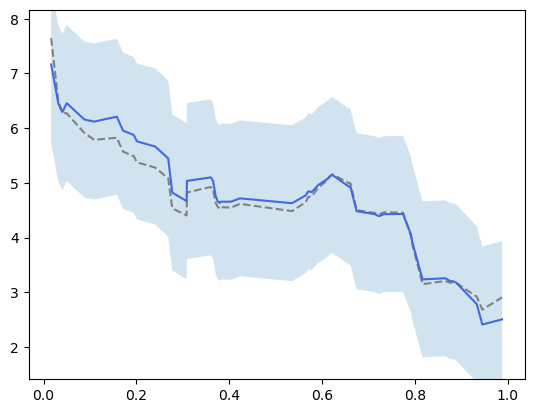

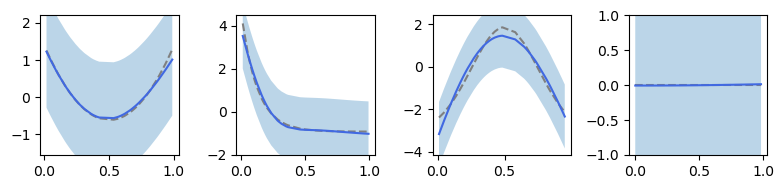

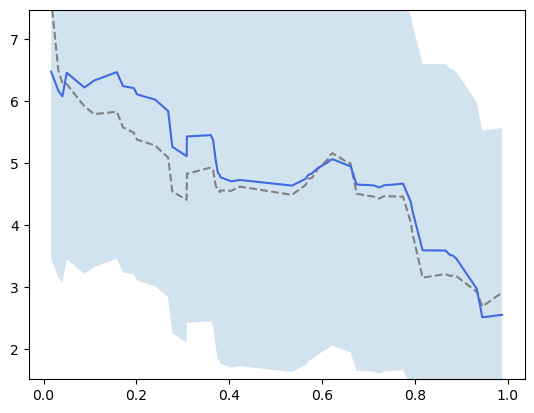

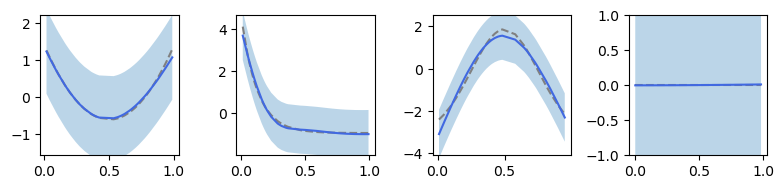

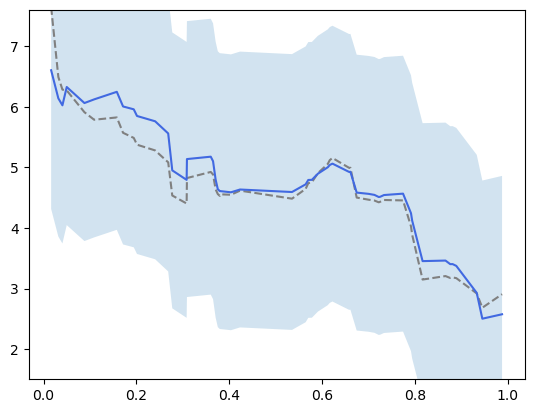

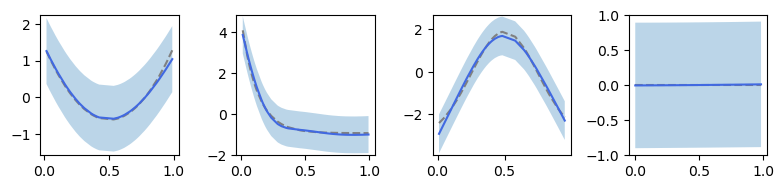

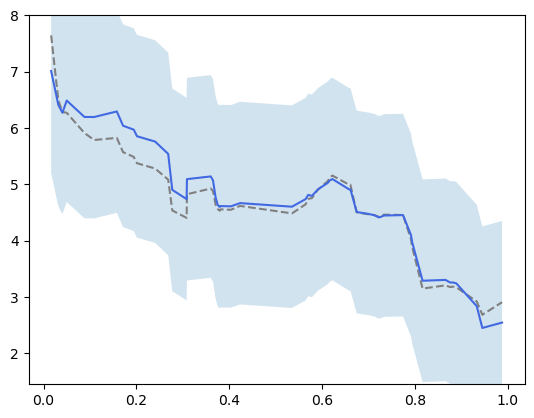

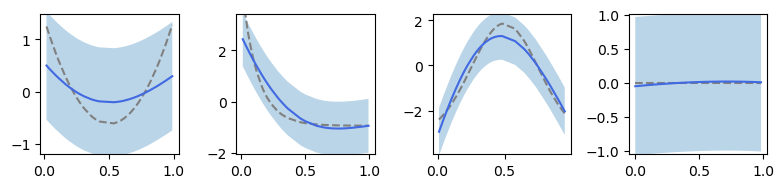

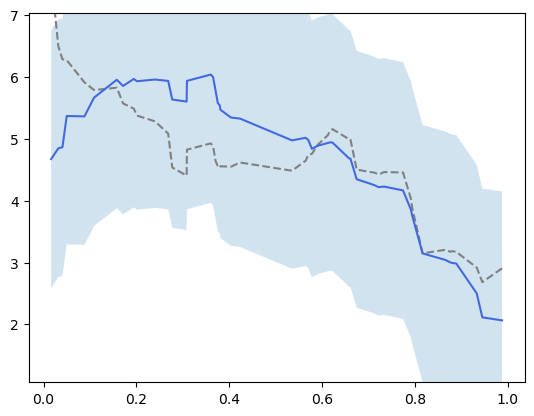

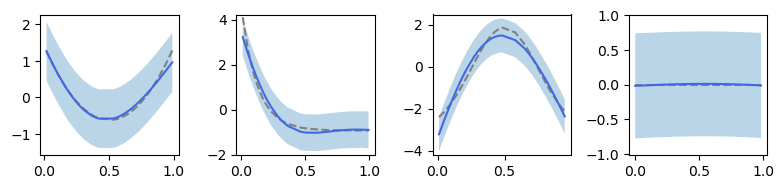

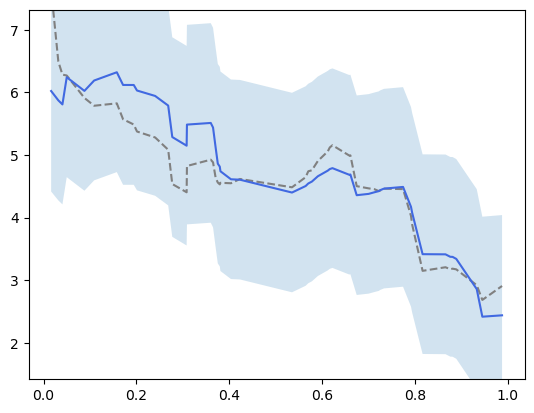

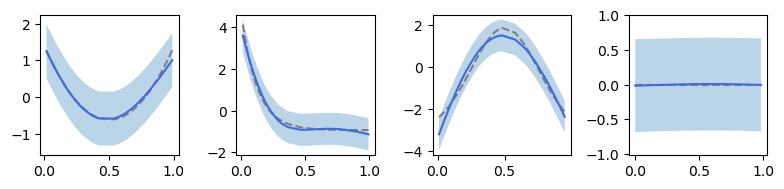

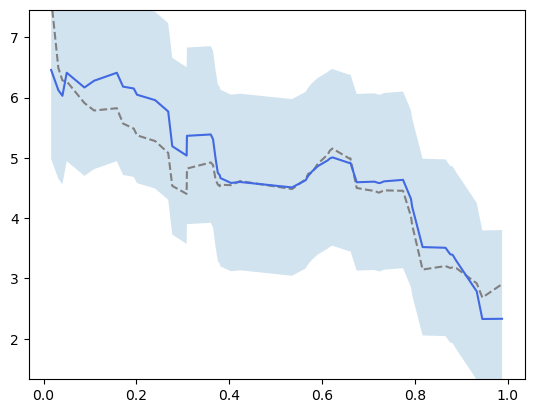

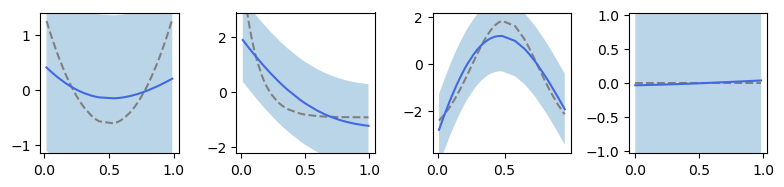

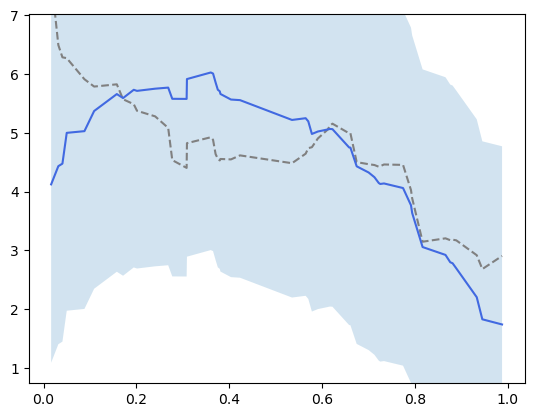

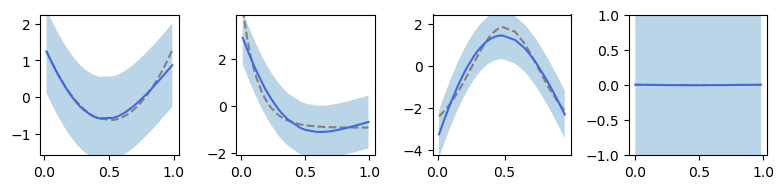

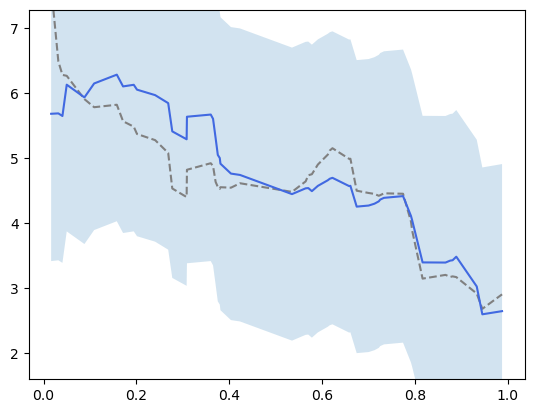

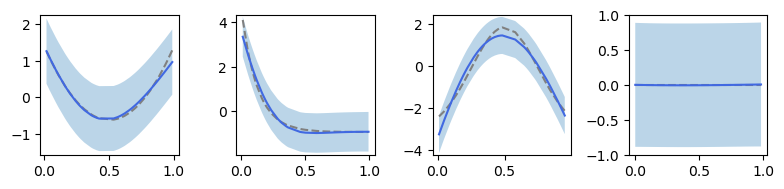

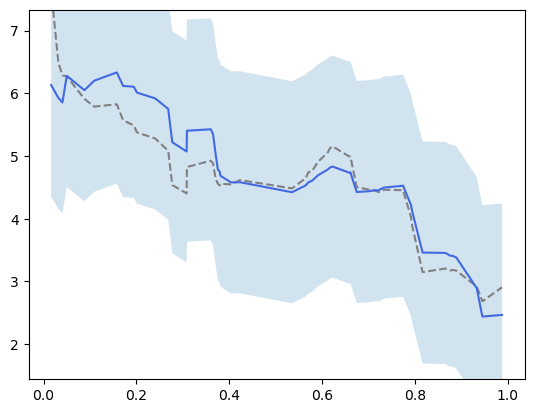

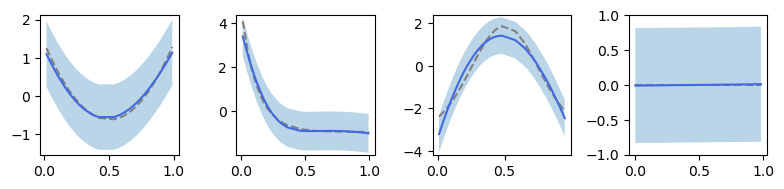

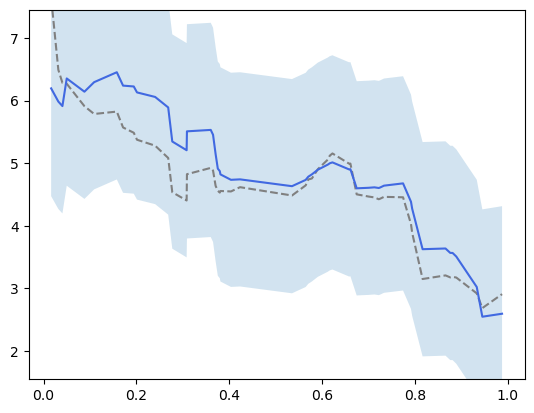

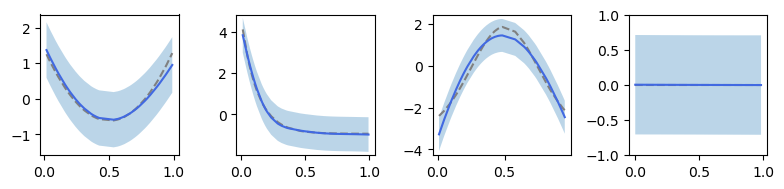

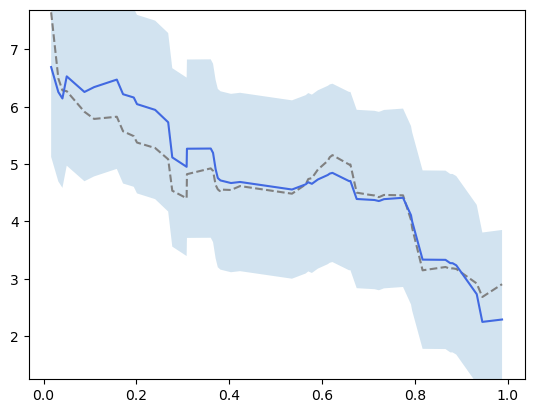

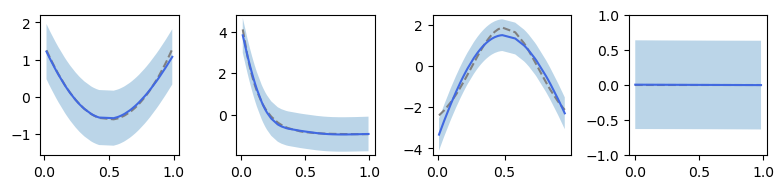

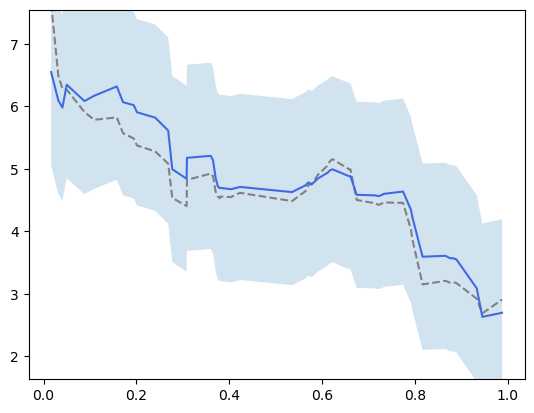

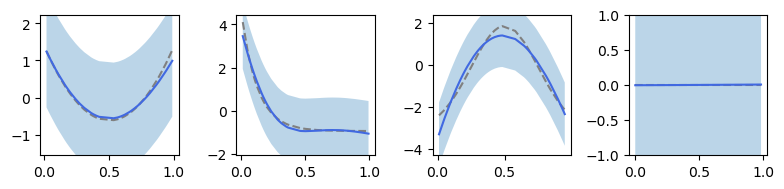

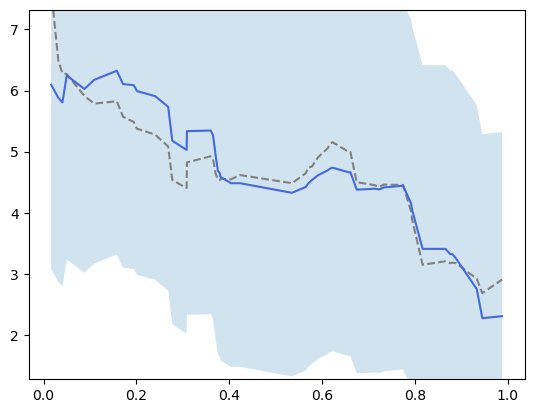

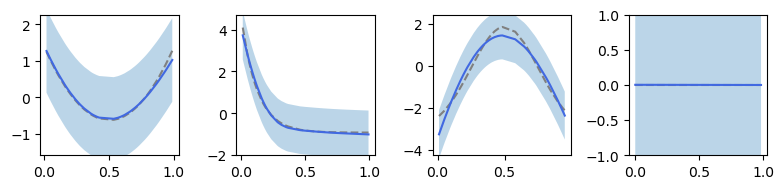

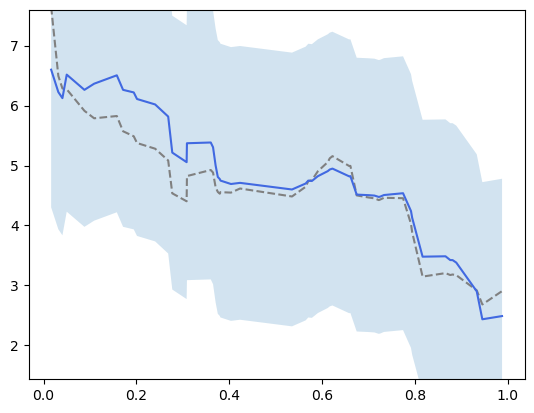

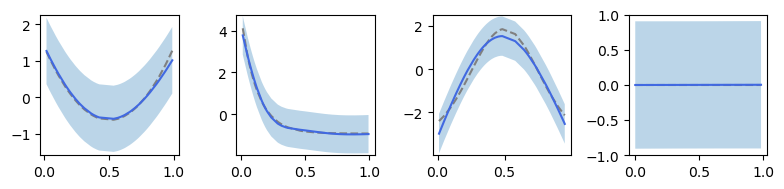

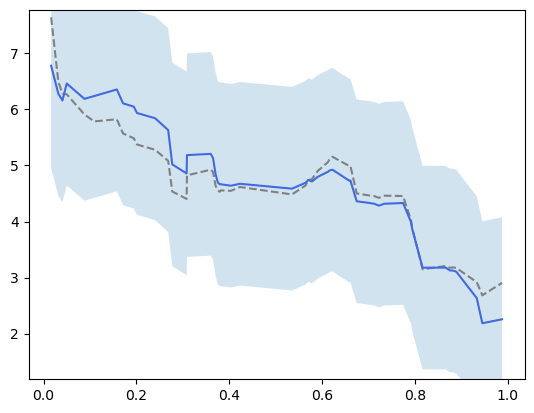

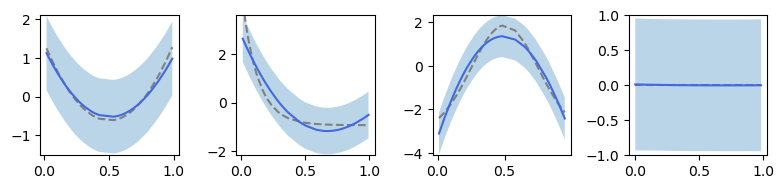

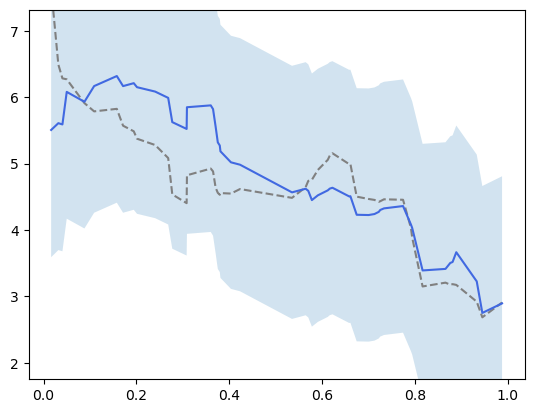

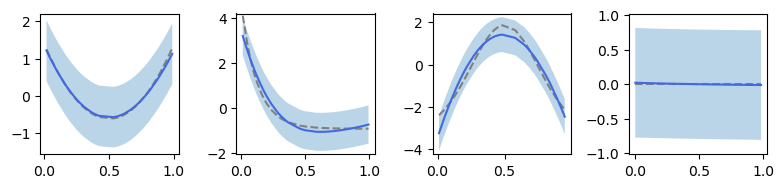

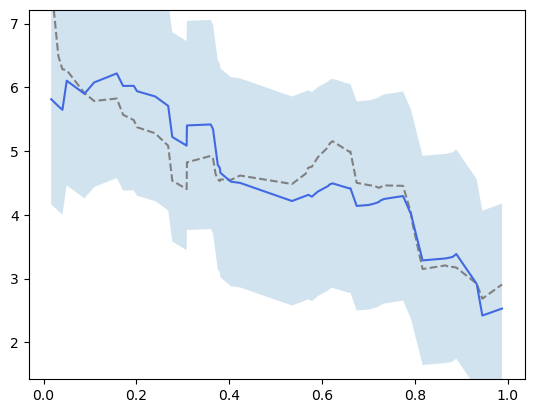

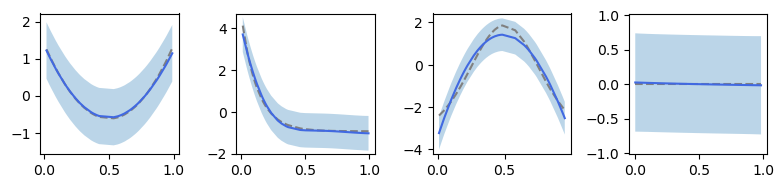

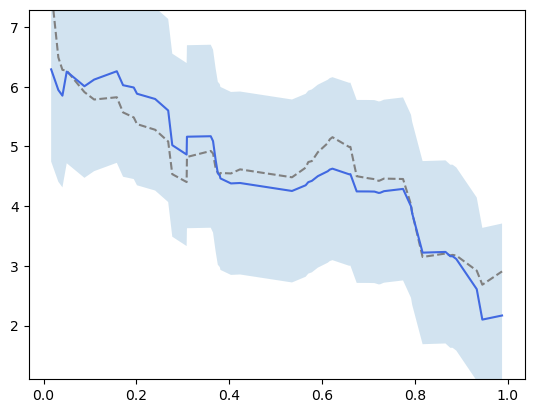

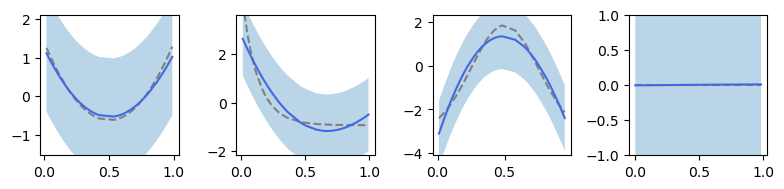

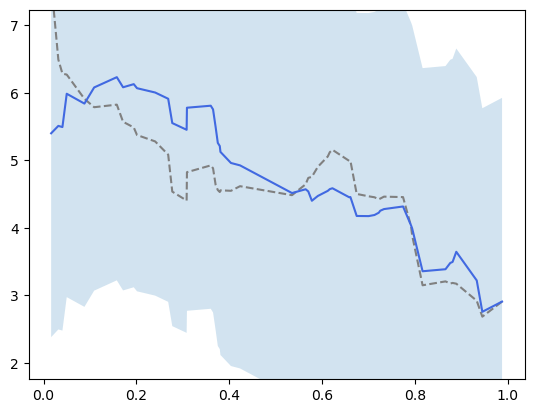

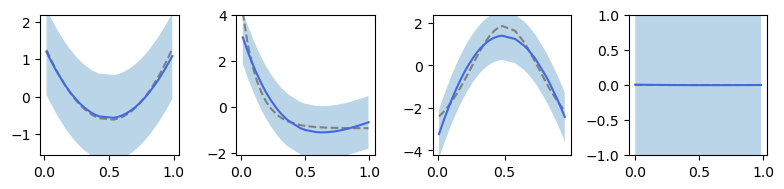

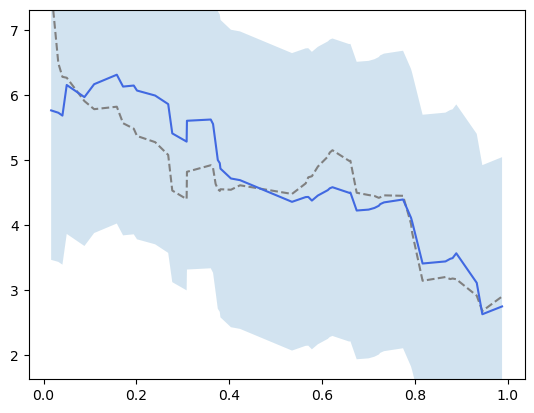

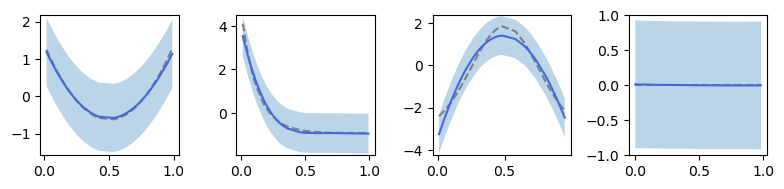

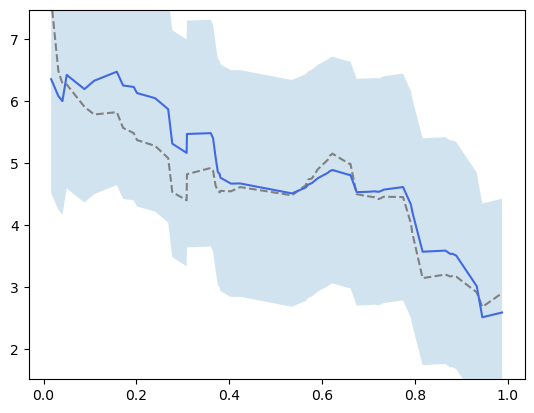

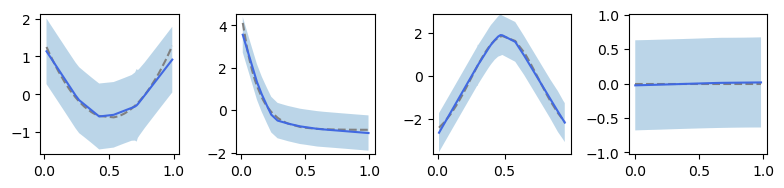

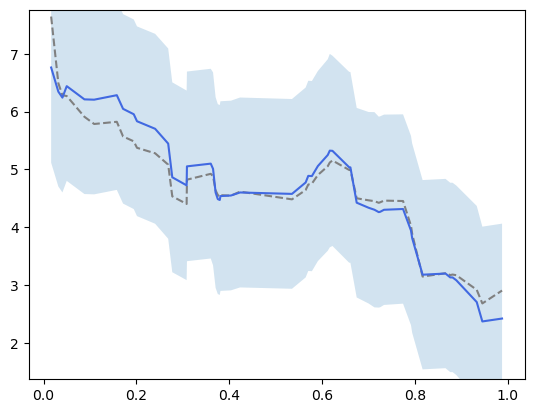

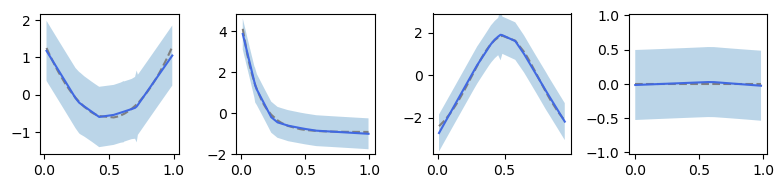

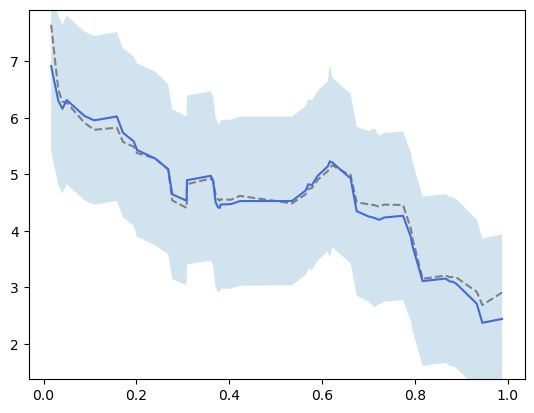

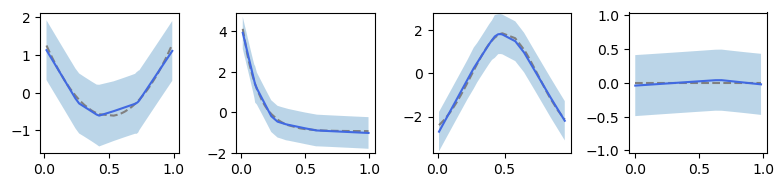

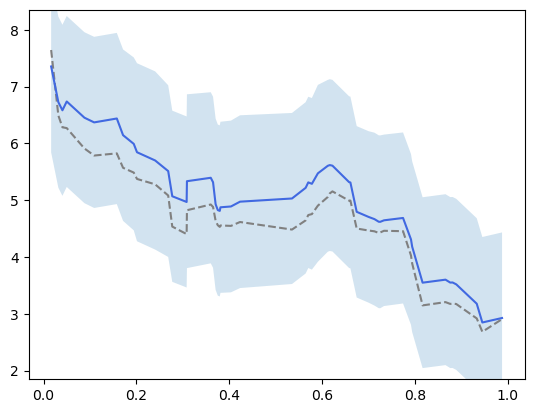

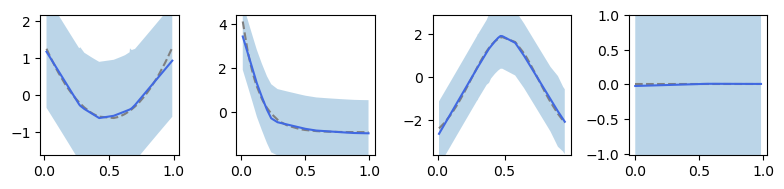

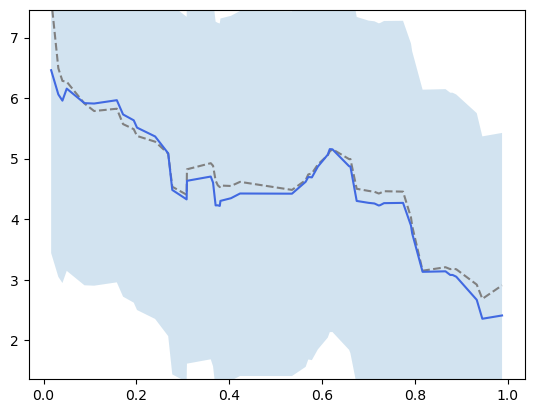

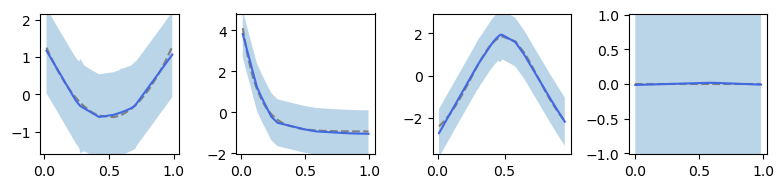

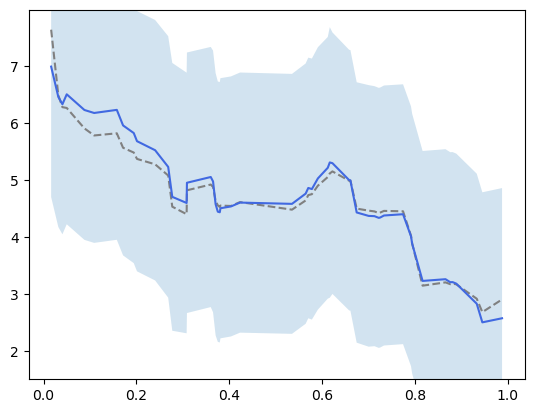

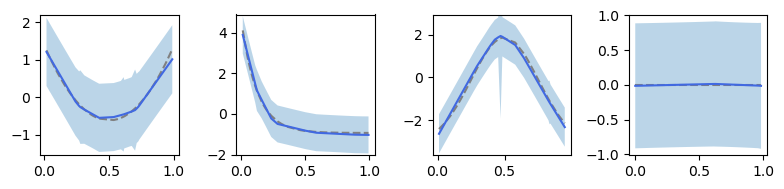

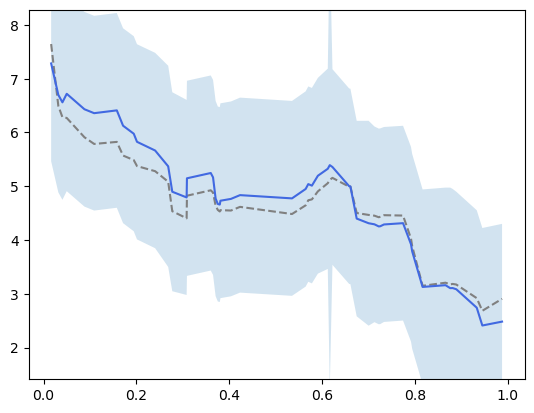

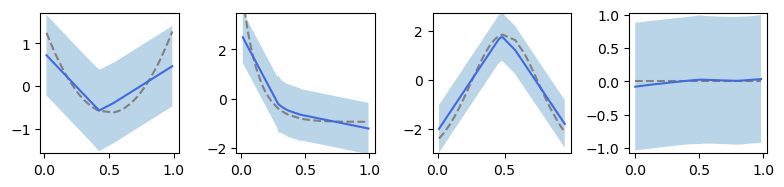

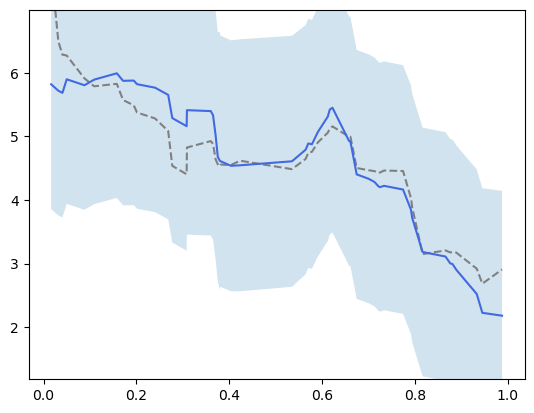

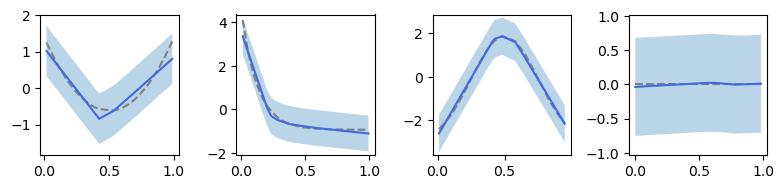

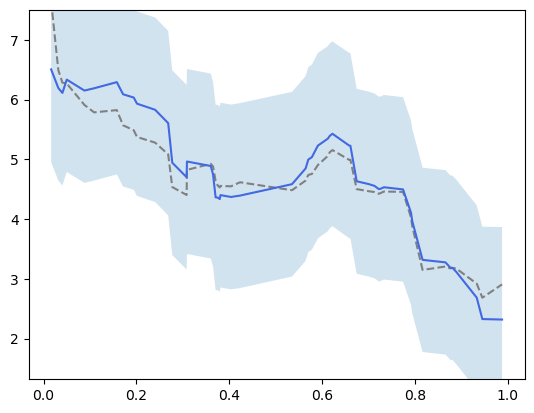

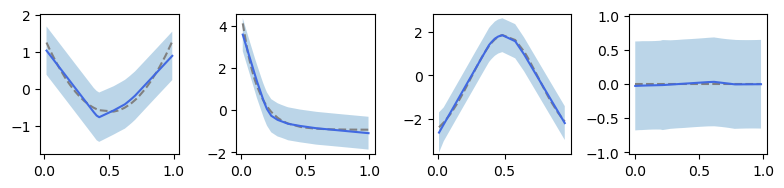

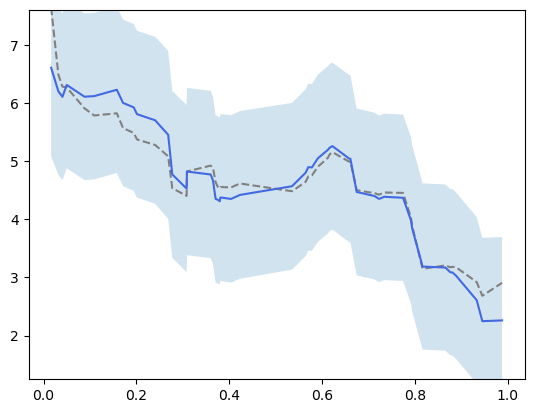

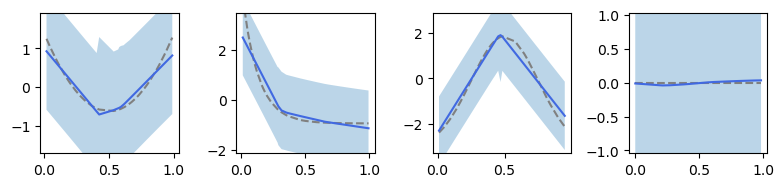

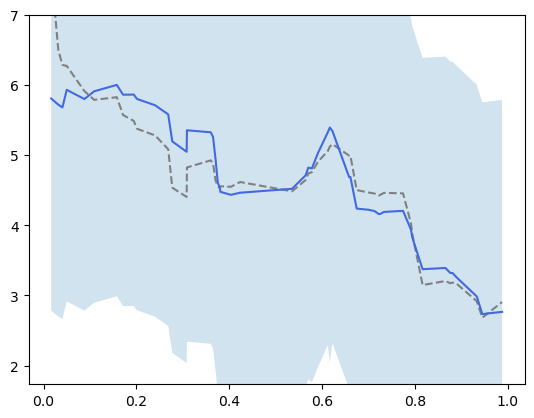

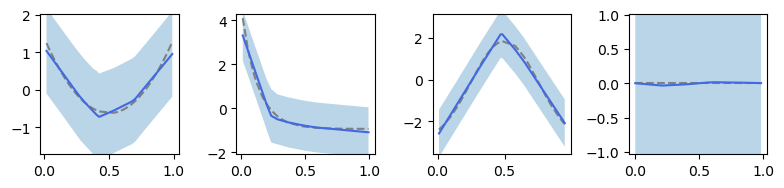

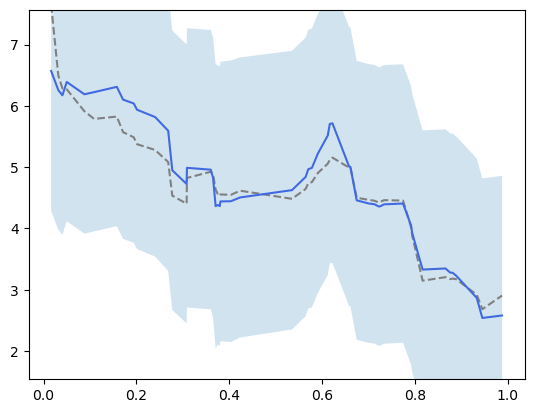

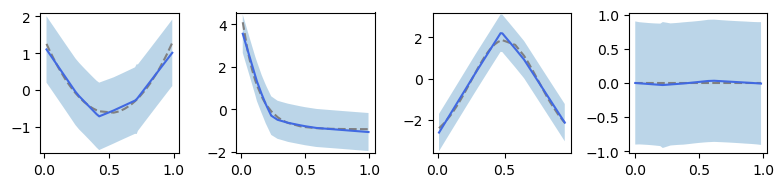

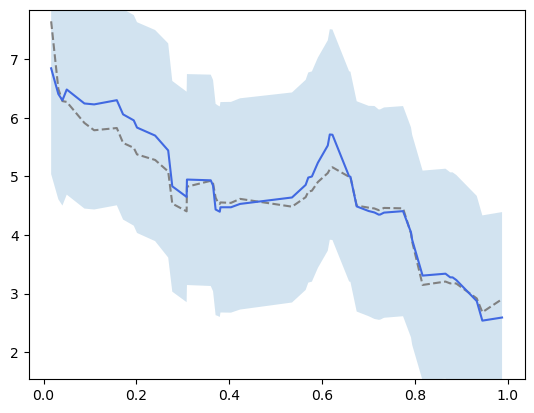

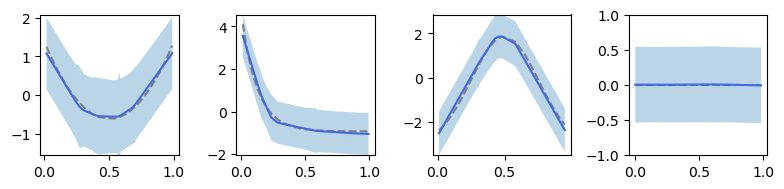

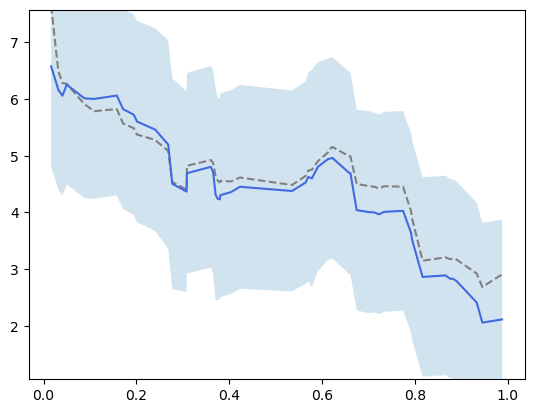

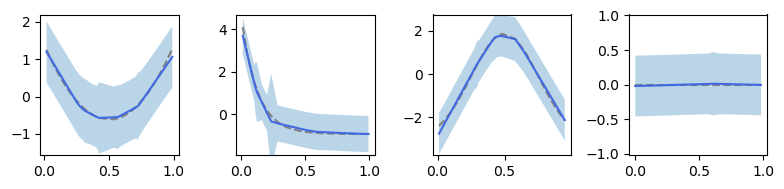

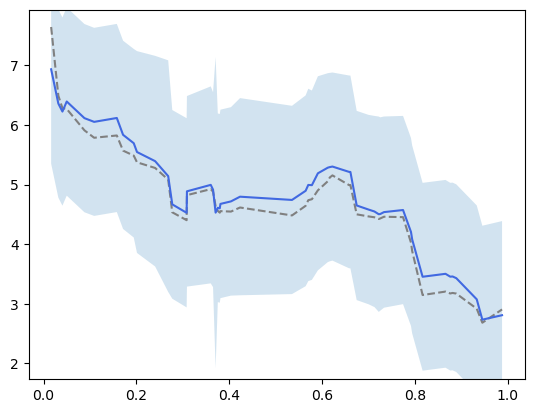

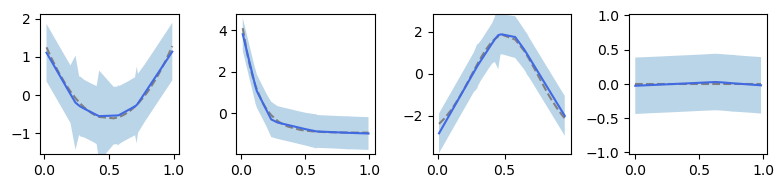

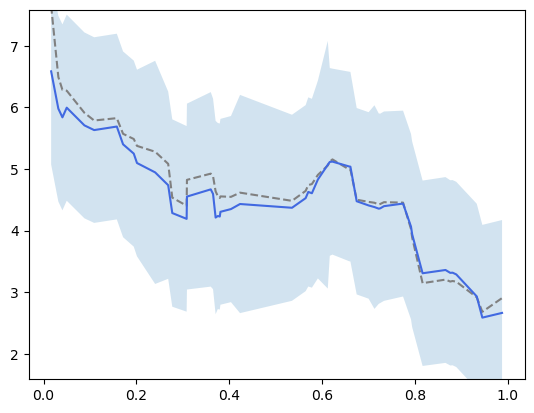

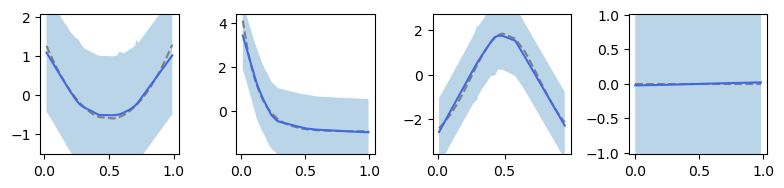

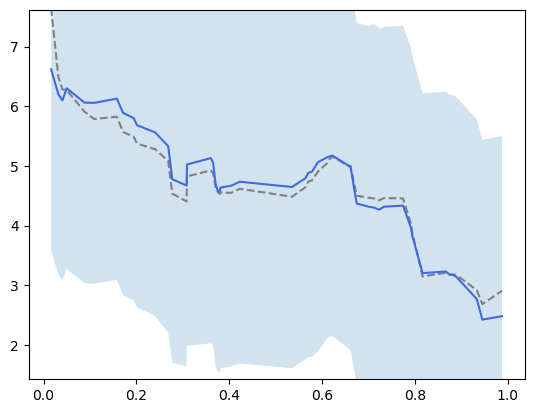

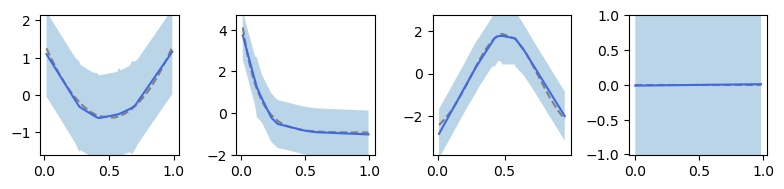

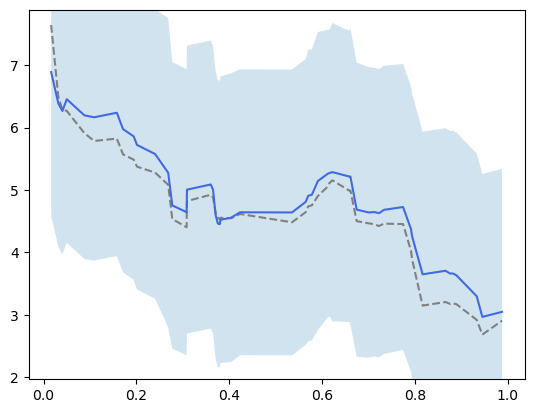

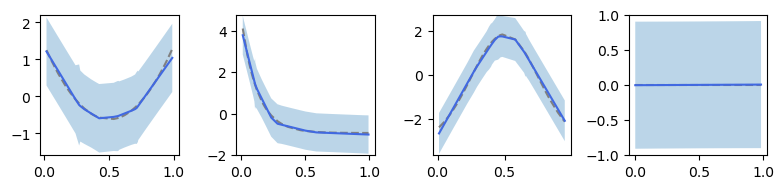

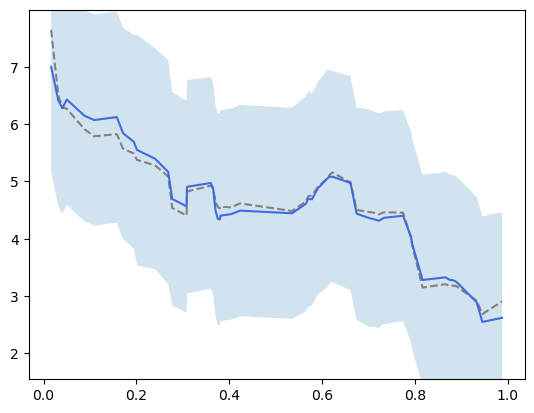

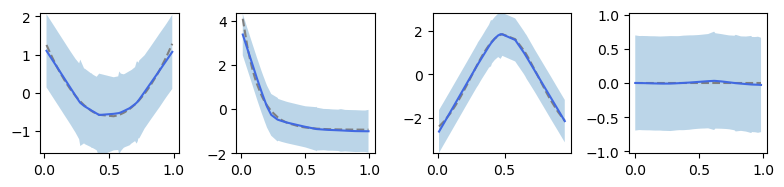

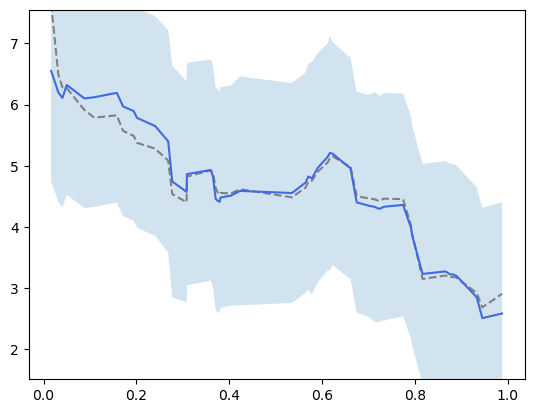

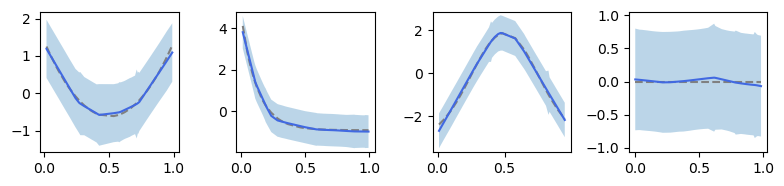

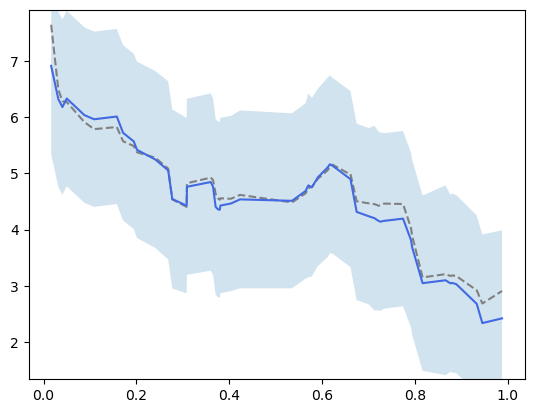

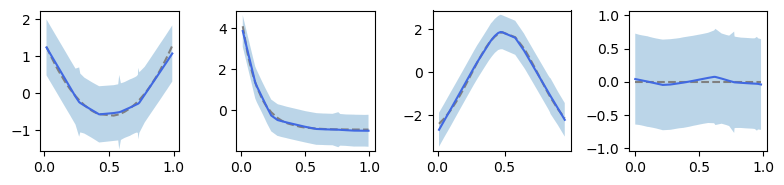

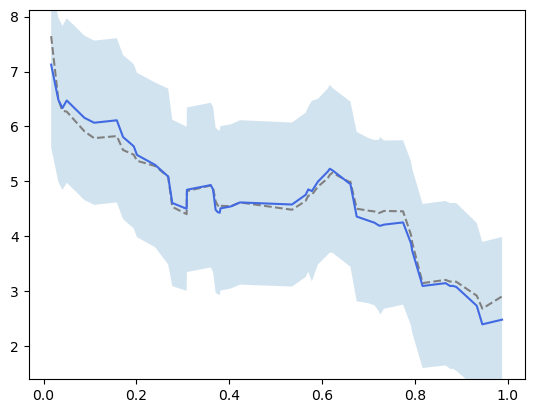

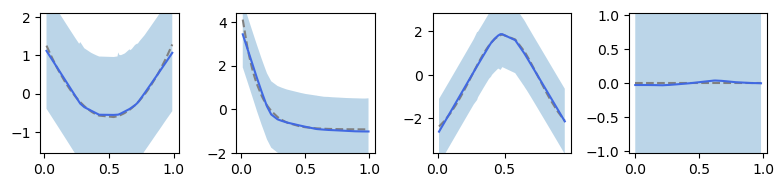

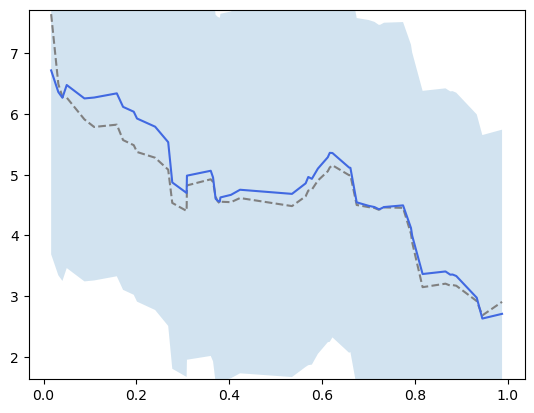

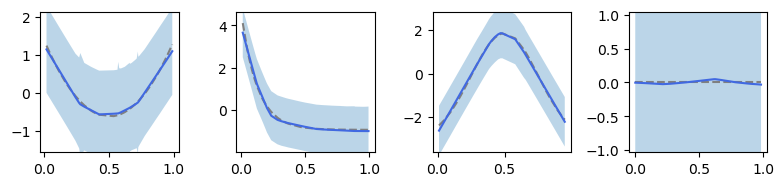

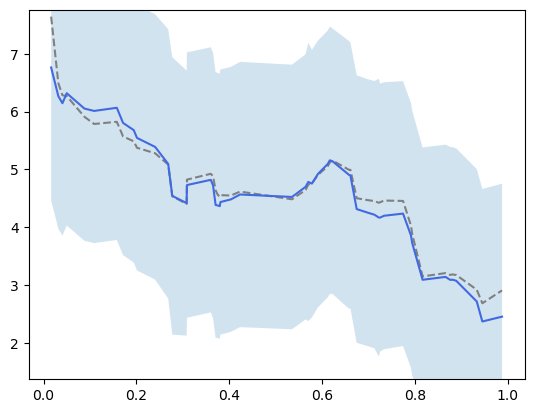

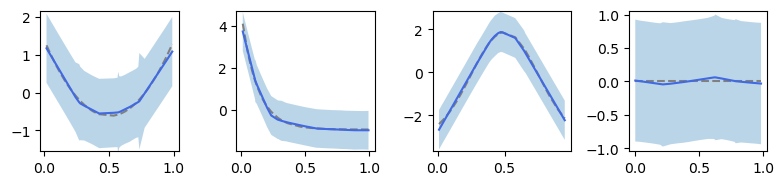

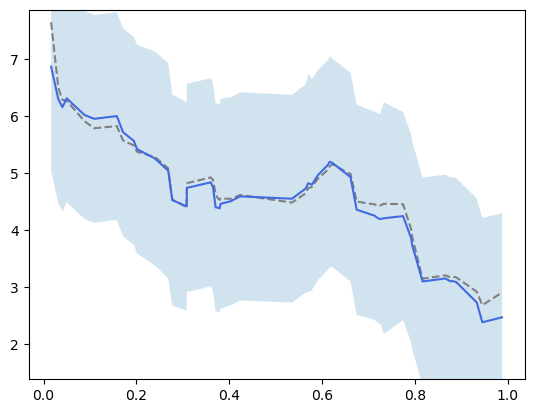

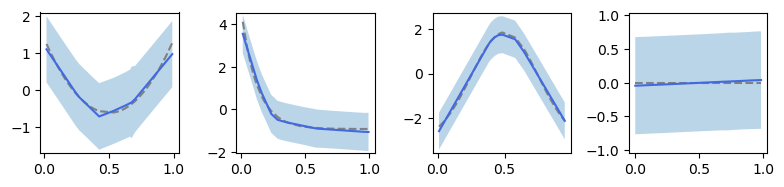

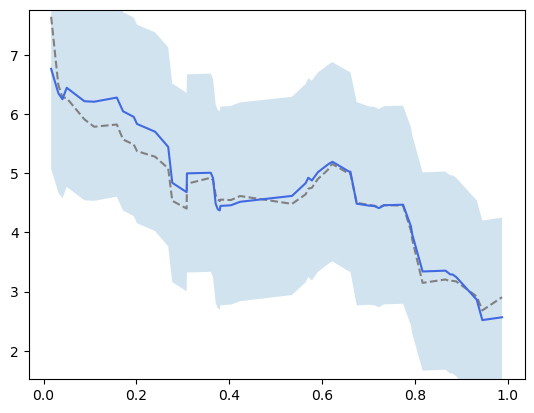

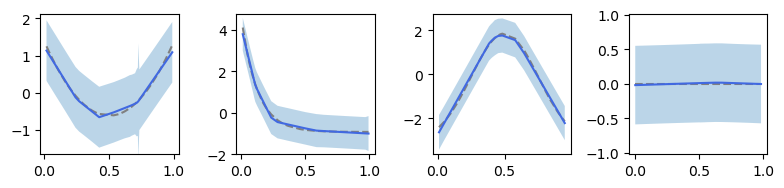

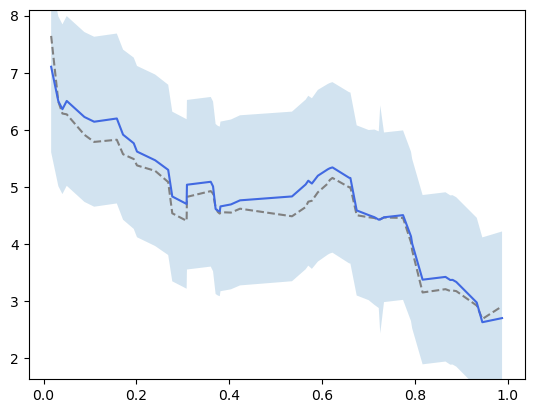

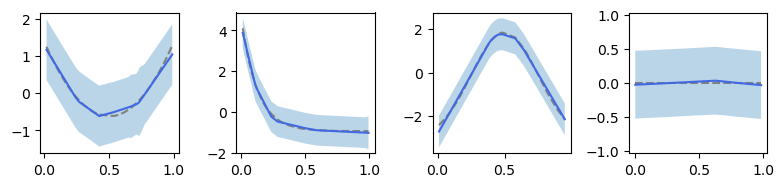

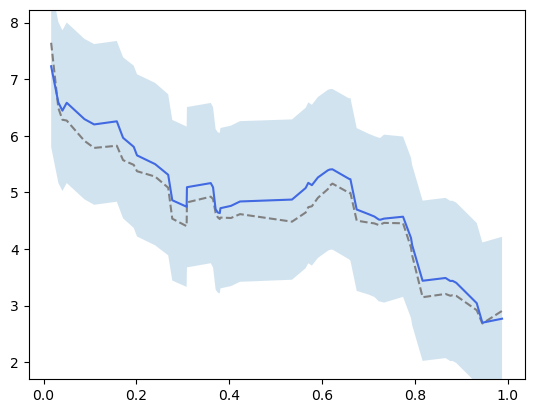

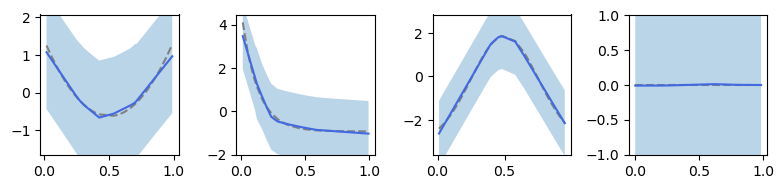

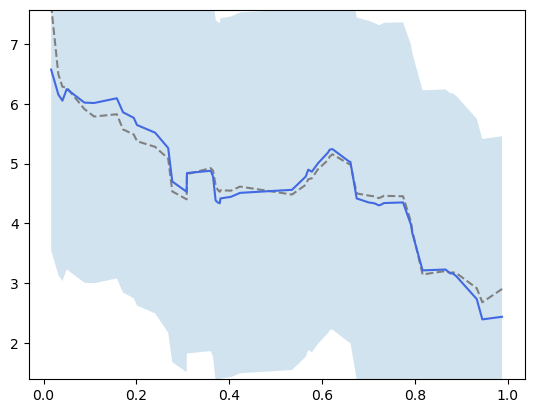

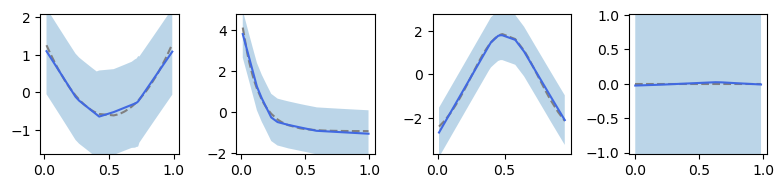

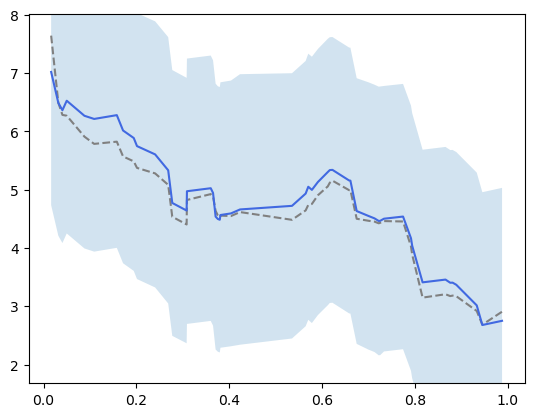

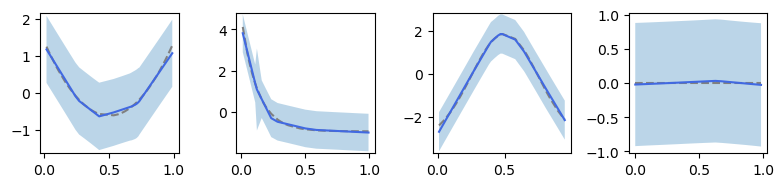

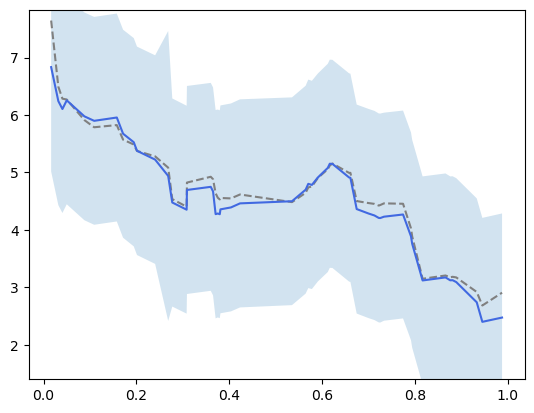

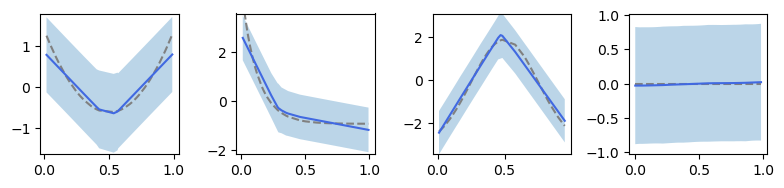

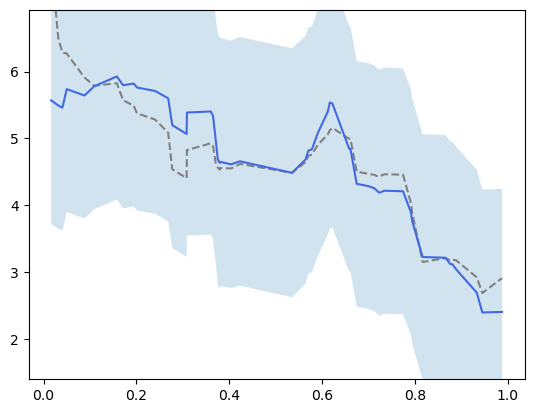

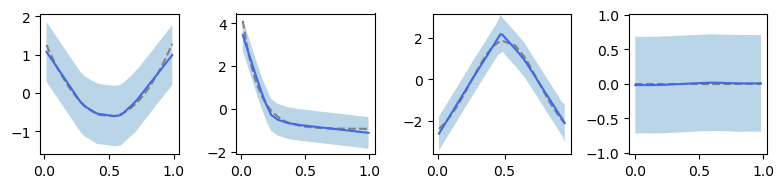

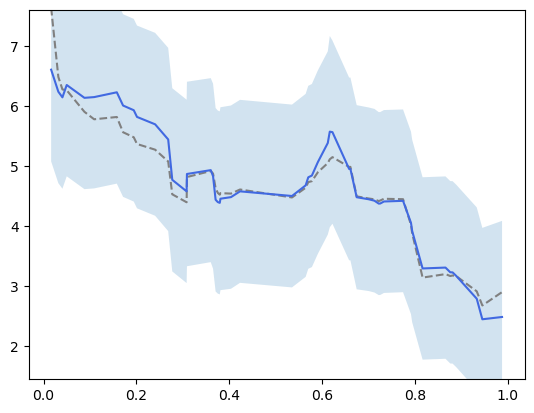

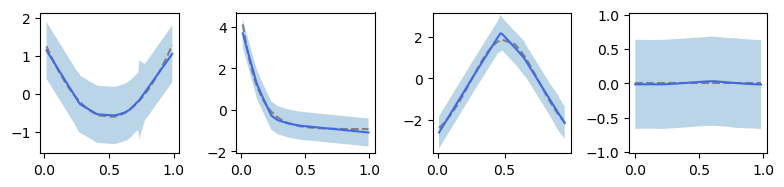

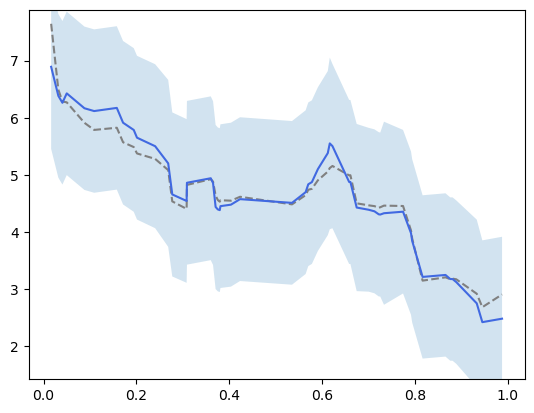

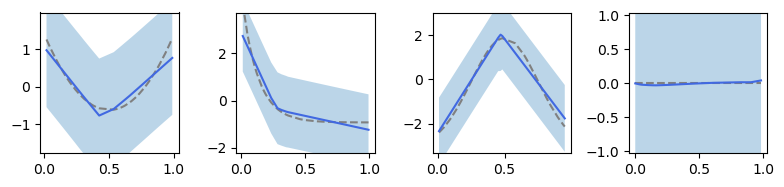

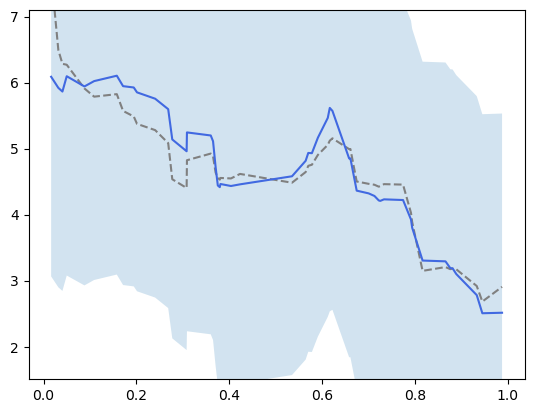

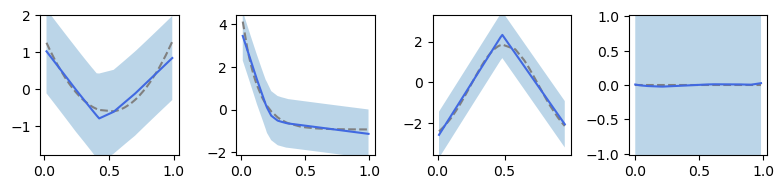

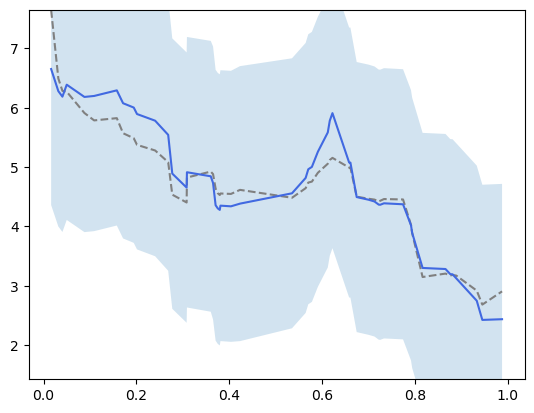

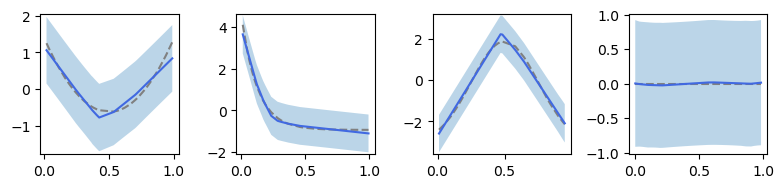

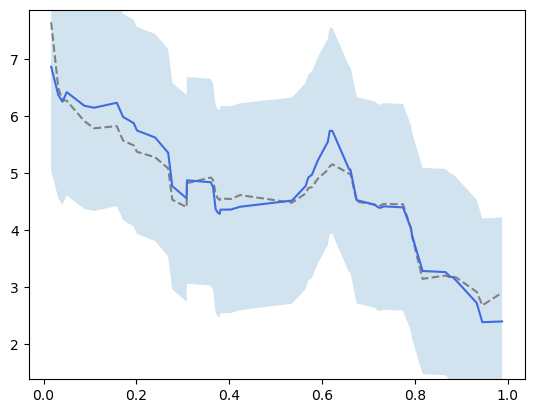

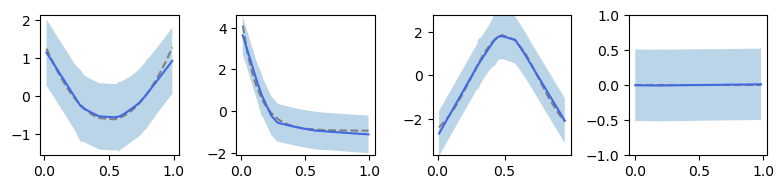

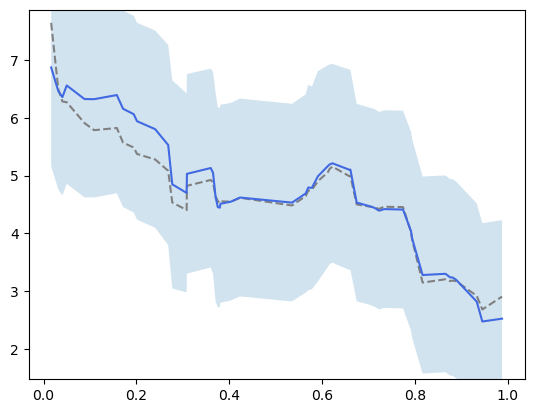

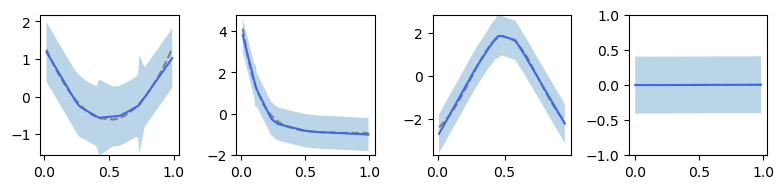

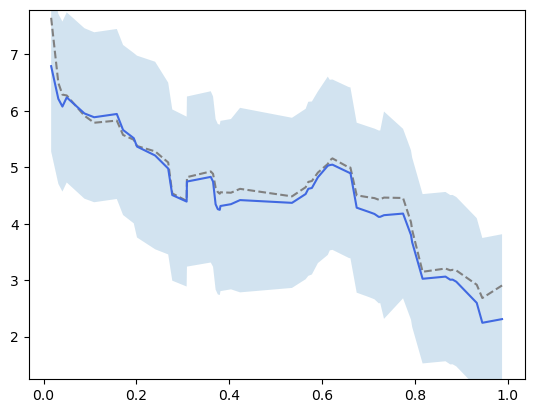

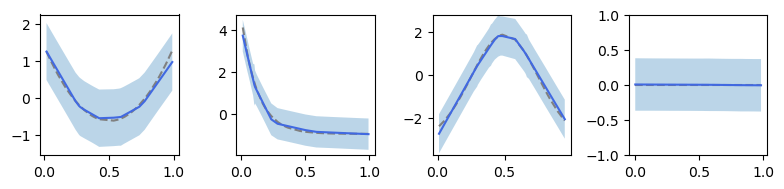

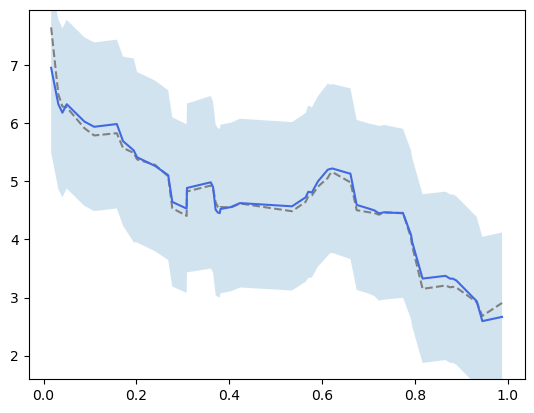

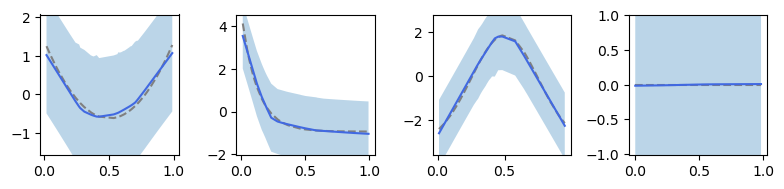

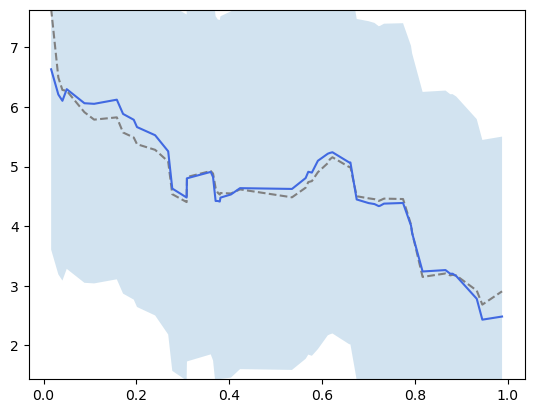

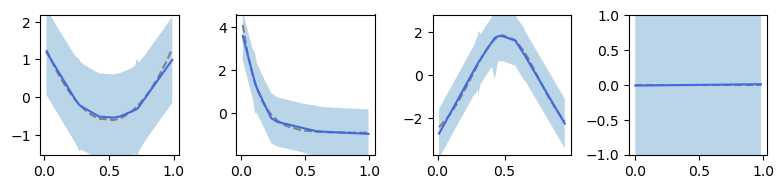

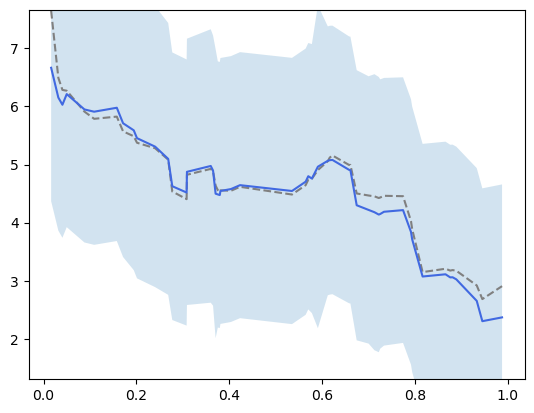

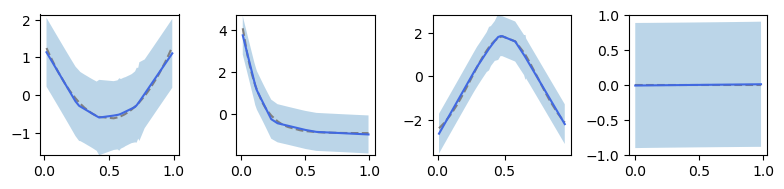

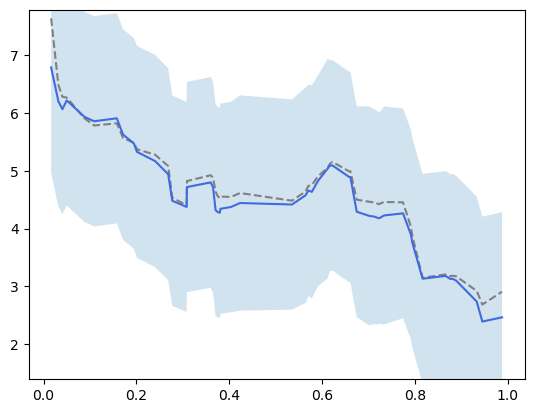

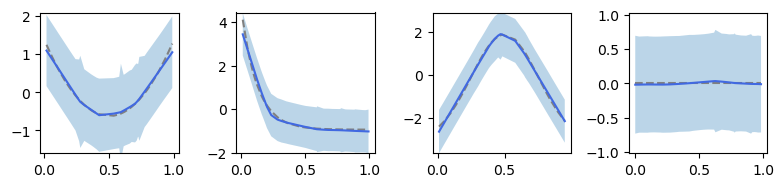

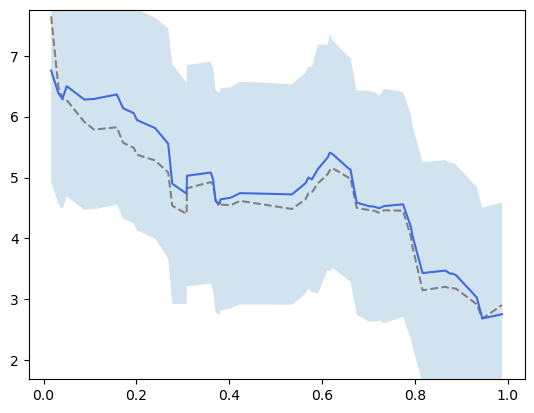

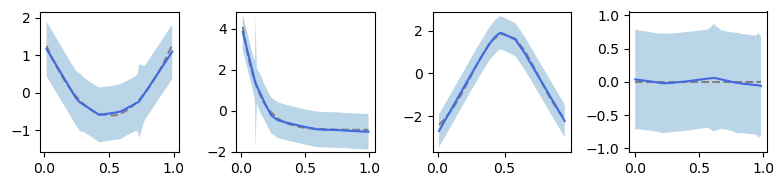

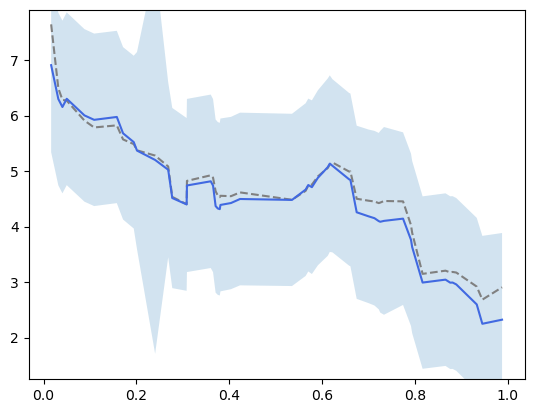

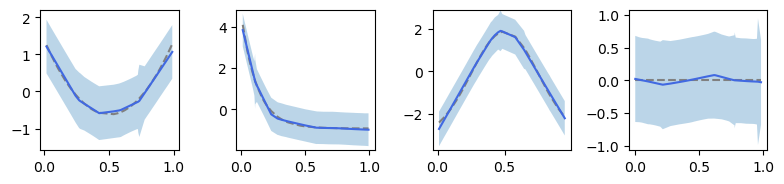

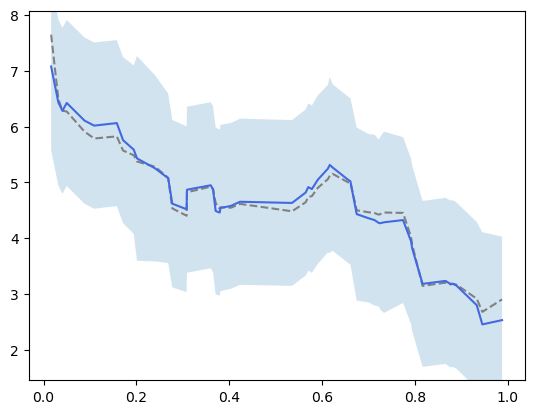

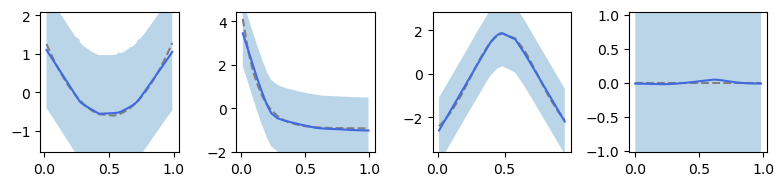

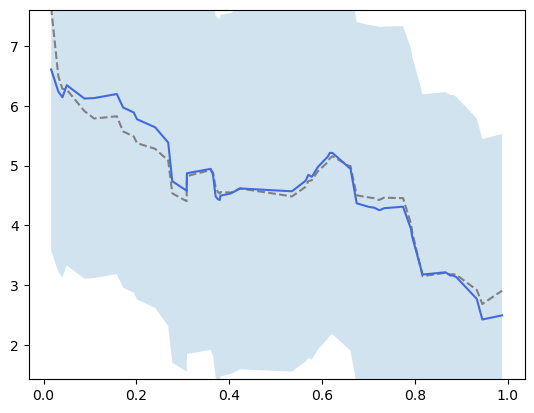

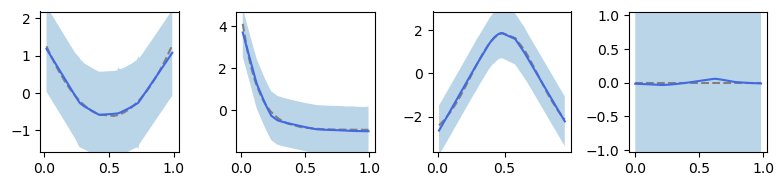

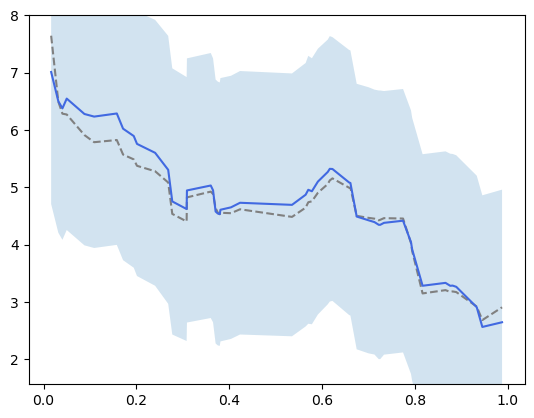

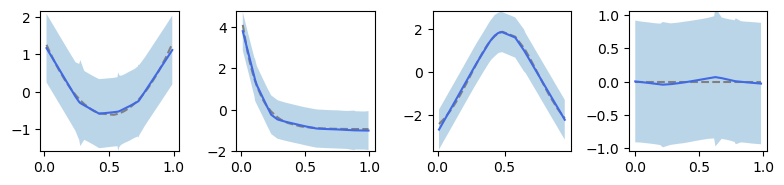

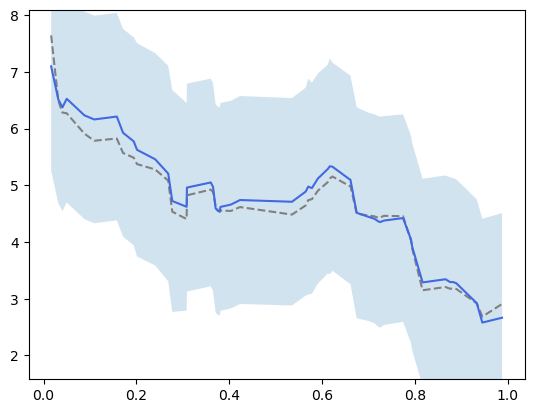

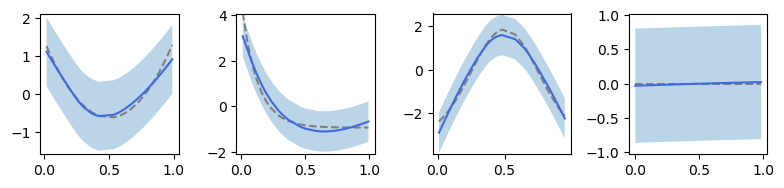

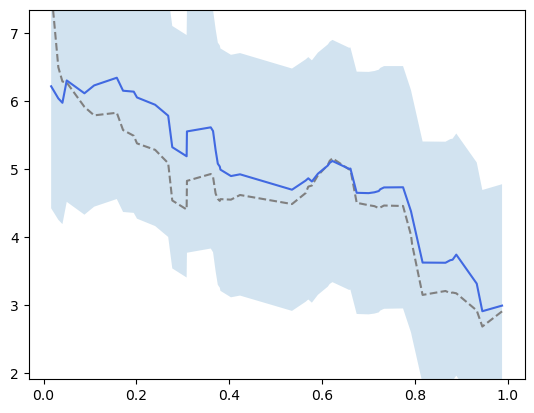

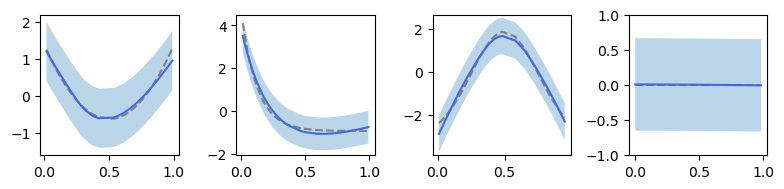

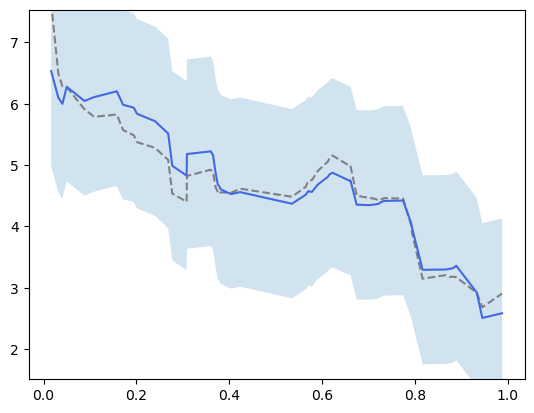

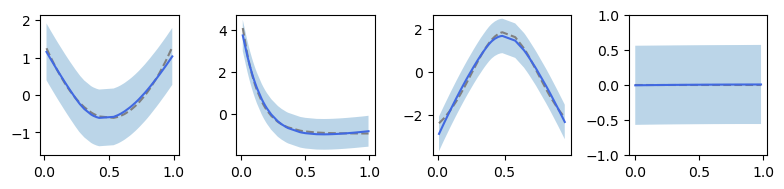

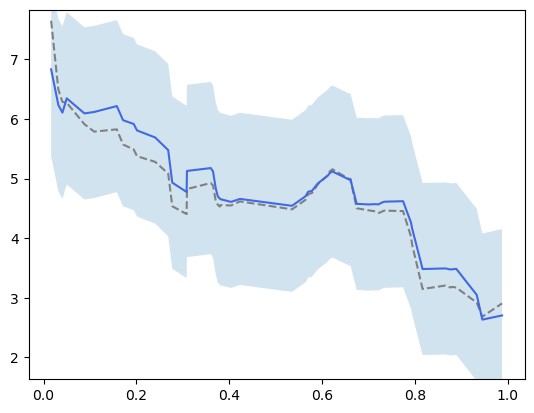

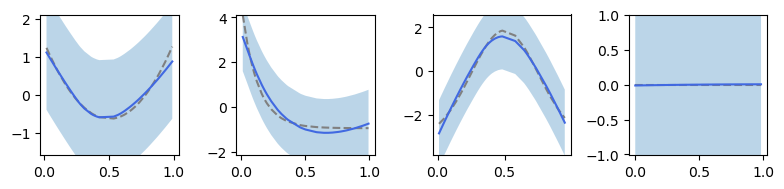

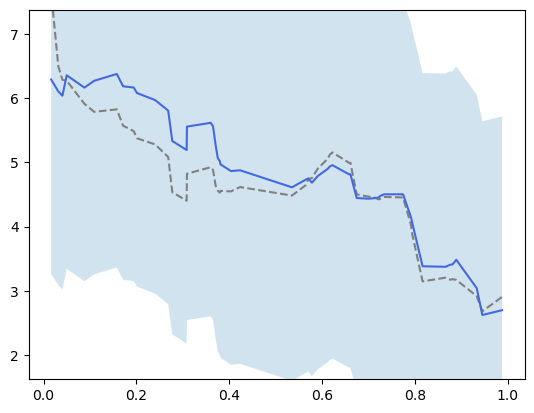

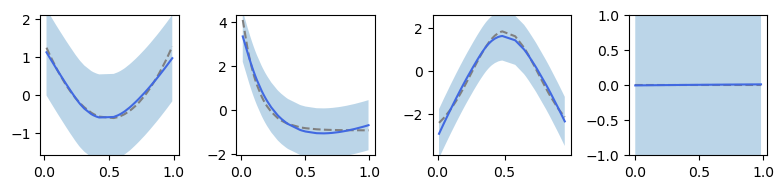

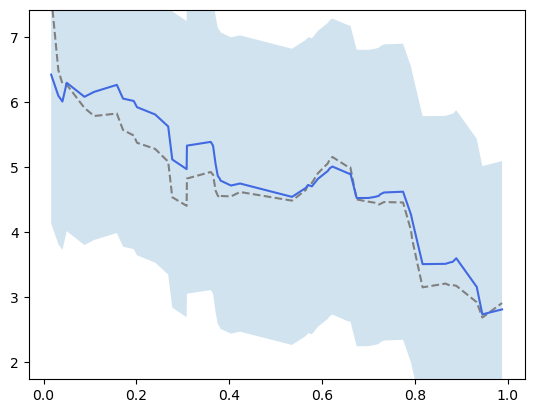

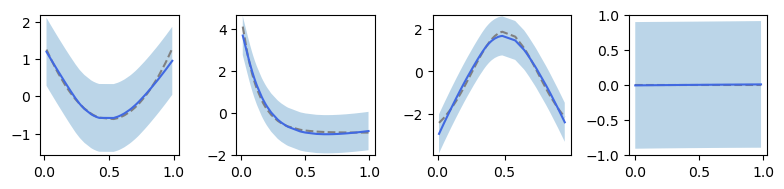

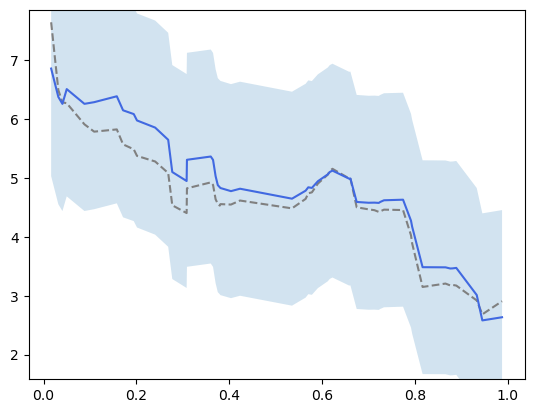

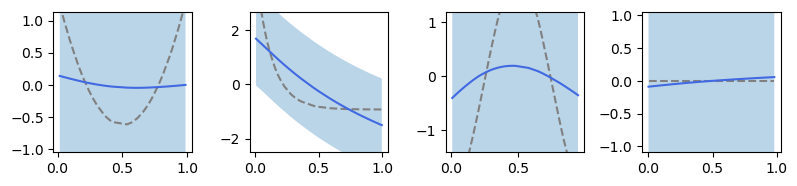

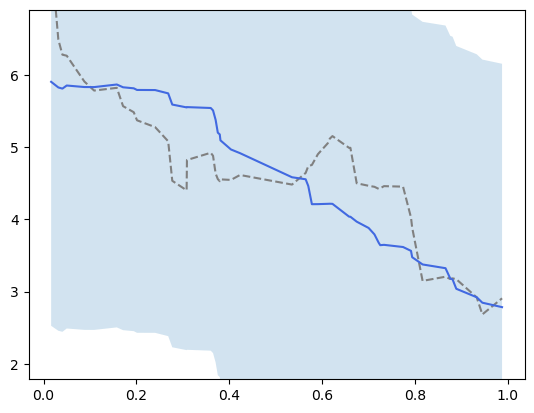

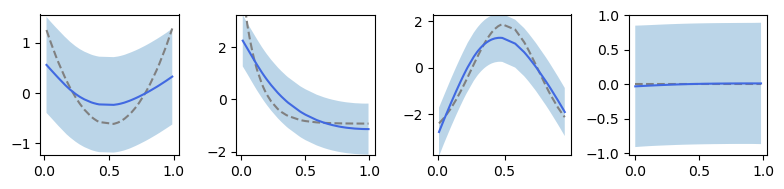

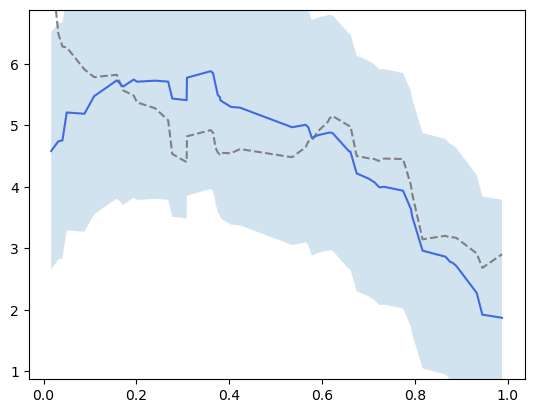

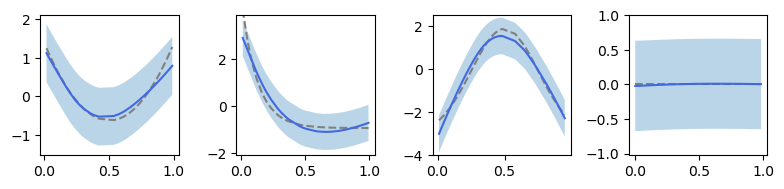

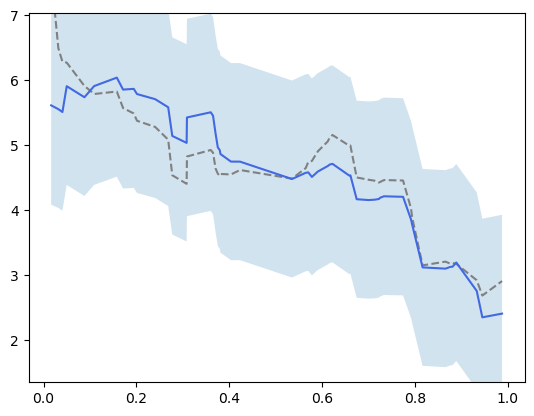

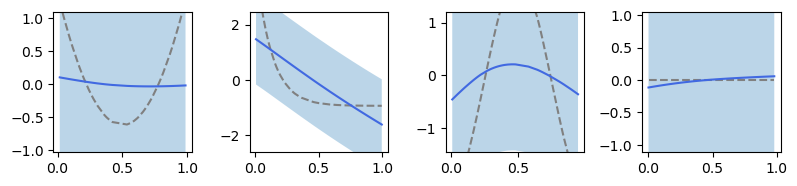

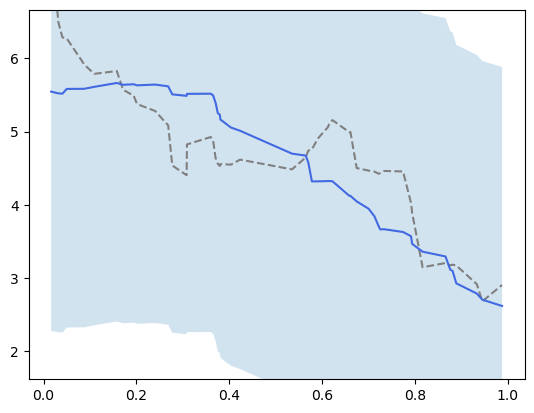

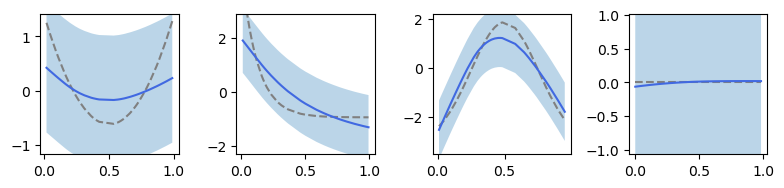

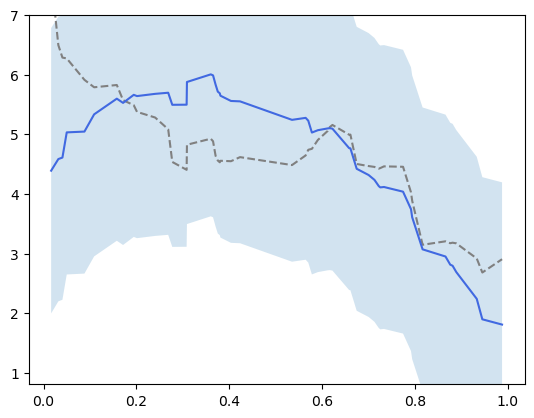

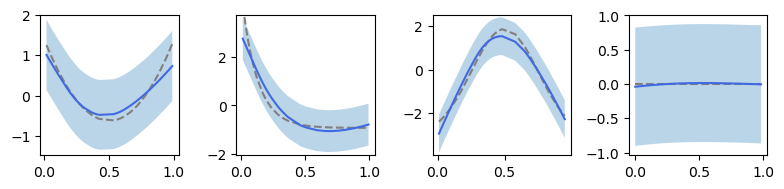

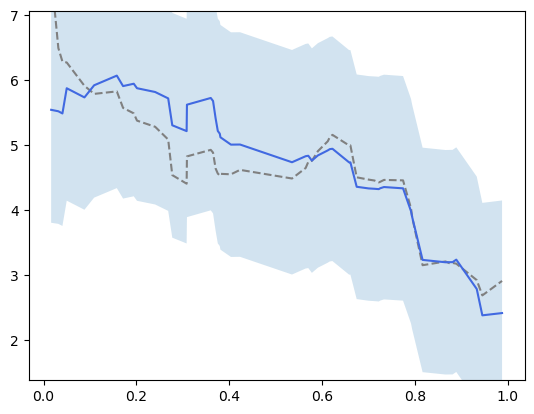

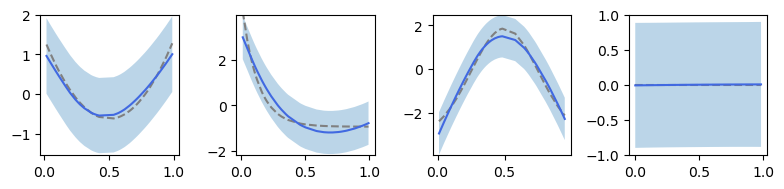

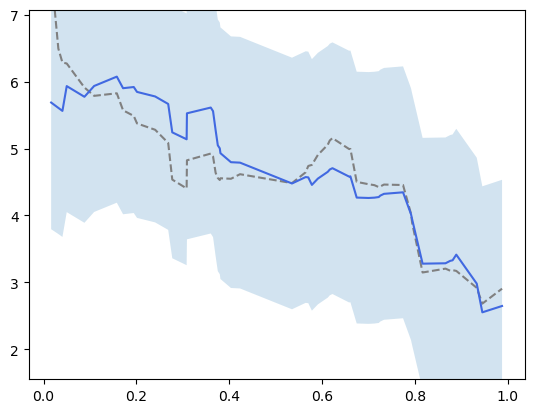

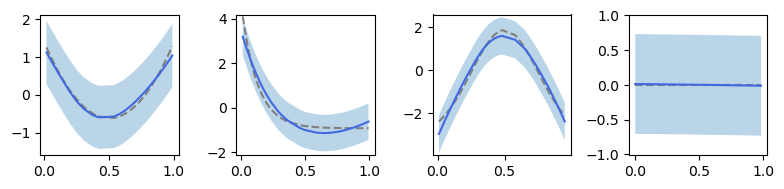

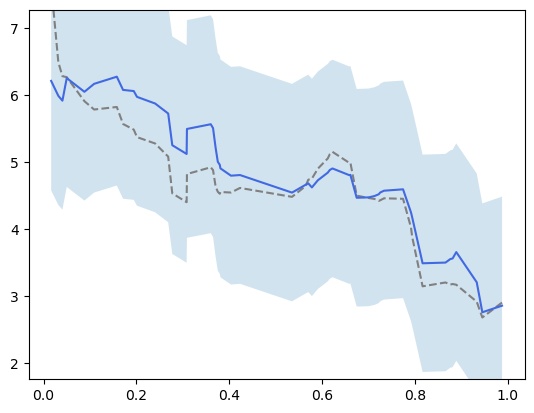

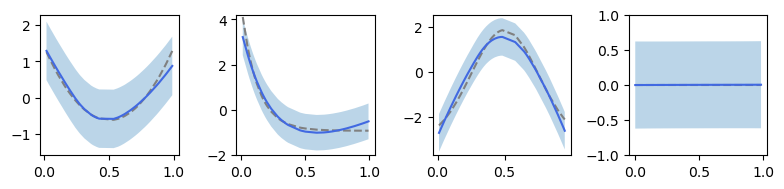

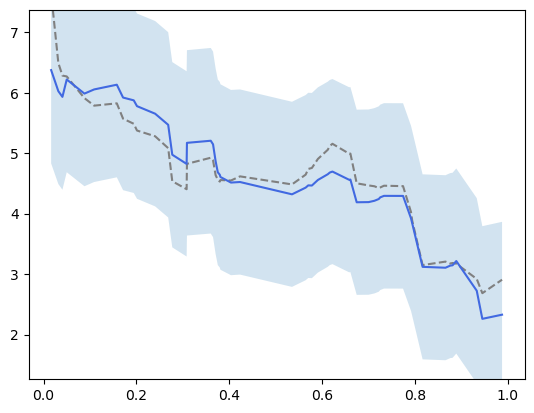

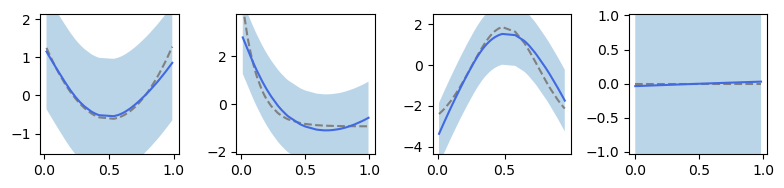

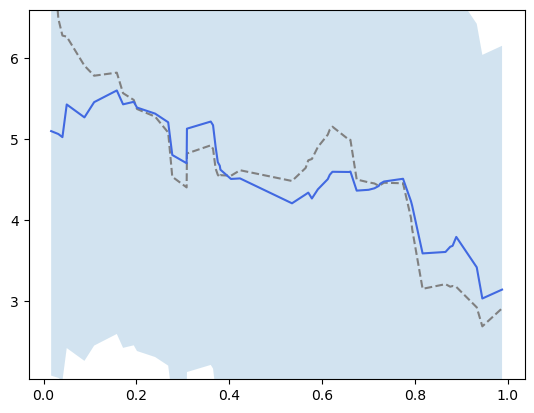

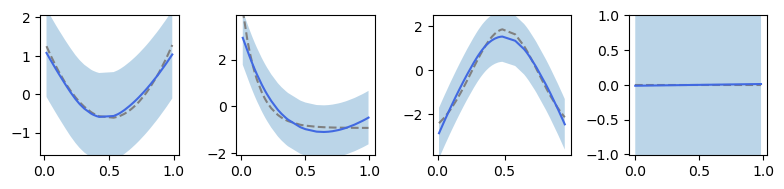

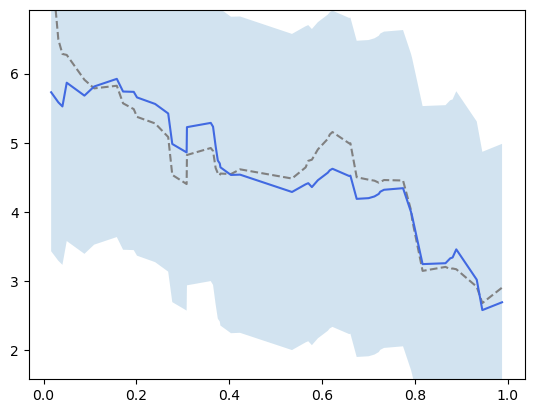

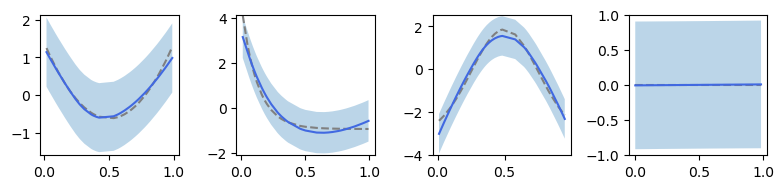

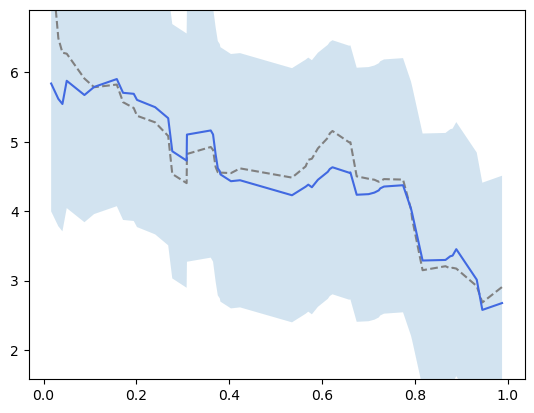

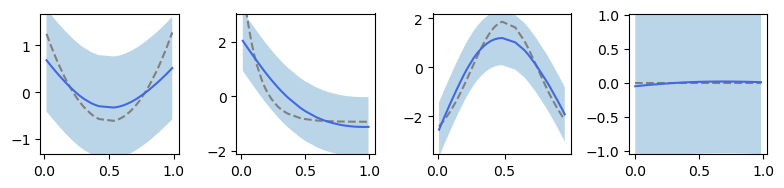

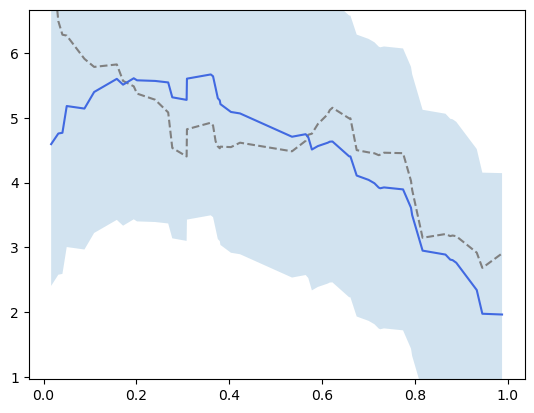

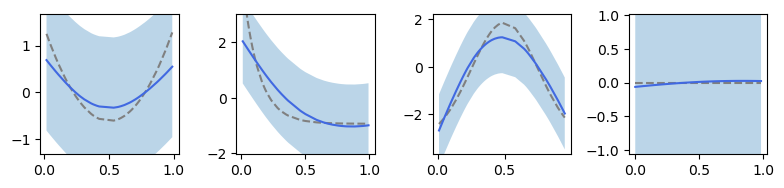

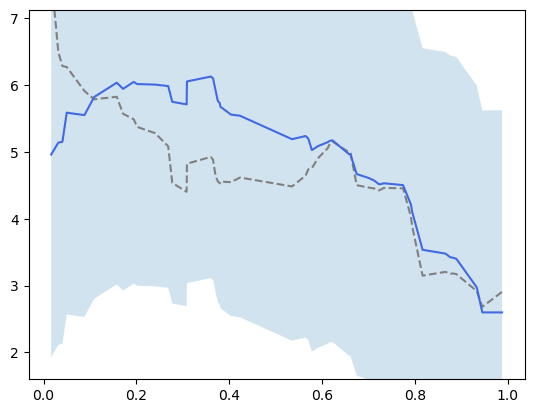

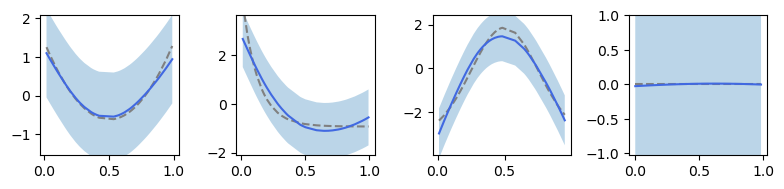

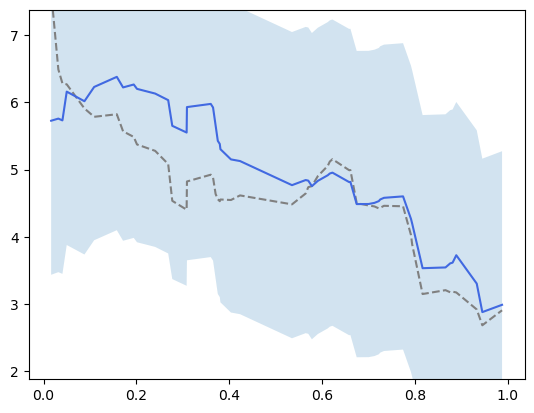

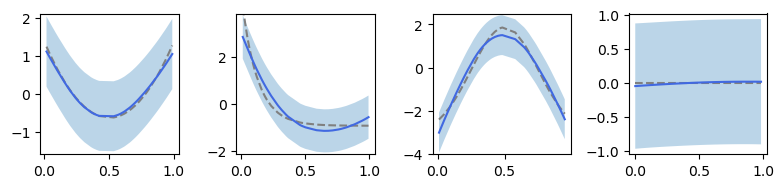

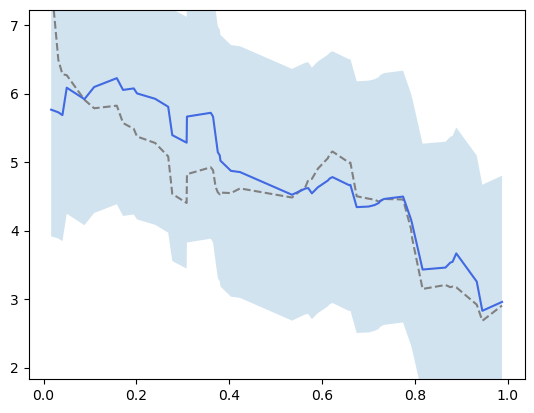

In [7]:
from functools import partial
wandb.agent(sweep_id, 
            function=partial(wandb_training, 
                             config=cfg, 
                             train_loader=train_loader, 
                             loader_fnn=train_loader_fnn,
                             testset=testset),
            count=40) # specify the maximum number of runs